<a href="https://colab.research.google.com/github/stcoats/VoD_toolkit/blob/main/VoD_toolkit_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VoD Toolkit v2

This notebook contains code for the collection of content from YouTube and Twitch for analysis of speech and chat from recorded live streams ("Video on Demand = VoD").


### 1. Google Drive

To connect to Google Drive, mount it in the Colab session. This will allow you to access files stored in your Drive directly from the notebook and to save outputs directly. You will be prompted to authorize Colab to access your Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

###2. YouTube cookies

YouTube uses cookies, for example to hinder bots and implement age verification. Some content that you wish to collect may require age verification, so you need to get the YouTube cookies file and make it available to yt-dlp.

1.   Search for the browser extension "Get cookies.txt LOCALLY". Install it in your browser.

<img src="https://i.imgur.com/3sIwYFh.png" width="75%">

2.   In the same browser session, go to YouTube and start watching any video.
3.   Access the extension by clicking the extensions icon in the browser.
4.   Download the .txt file in Netscape format by clicking the "Export" button.

<img src="https://i.imgur.com/ww1AjO5.png" width="50%">

5.   Upload that cookies.txt file to Colab or wherever you are running the notebook.

The cookies file expires after a period of time. If you run the yt-dlp script below and see a message that the cookie has expired, re-do the steps above.

###3. Install packages

Install the necessary Python packages.

In [1]:
%pip install -U yt-dlp[default,curl_cffi] certifi webvtt-py faster-whisper emoji==0.6.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.0/182.0 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 52.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 MB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.0/39.0 MB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 115.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.4/194.4 kB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 128.7 MB/s eta 0:00:00
  Created wheel for emoji: filename=emoji-0.6.0-py3-none-any.whl size=49719 sha256=895ab91b9ba08e5811e74a4ea4f751debe79b9636d7fa6beb0d285b847cb6491
  Stored in directory: /root/.cache/pip/wheels/0d/bf/a2/536017b4a6232aef0fb92831af35facd6590c0af0f

###4. Import packages

In [2]:
import os
import pandas as pd
import re
from pathlib import Path
from bs4 import BeautifulSoup
from IPython.display import HTML
import yt_dlp
import glob
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from google.colab import files

###5. Get a YouTube transcript + live_chat

Use the code below to retrieve content from YouTube.

`download archive`: This keeps track of what files you have downloaded, so you don't download them again in a new session. Note that because Colab sessions are not persistent, you want to make sure that this file is saved locally with each Colab session. The local file should be uploaded to Colab before each download session.

`cookiefile`: If you get a "restricted content" message, uncomment the cookiefile line. Get the cookie as above, and put it in the default directory. If you still get an error, try going to YouTube in your browser, refreshing the page, getting a new cookie file, and making it available to the session.  



In [3]:
#URLS = ['https://www.youtube.com/@PewDiePie/streams']  #The YT address with all the recorded streams
URLS = ['https://www.youtube.com/watch?v=RrFMFwjNKxU']


ydl_opts = {
    # Specify the file to keep track of downloaded video IDs
    #'download_archive': './downloaded_videos.txt',  #This is your archive of downloaded files.
    #'cookiefile': './cookies.txt', #This is the cookies file you got from YouTube
    'writesubtitles': True, #We want to get any subtitles uploaded for the video
    'writeautomaticsub': True, #We also want ASR subtitles
    'subtitleslangs': ['en', 'live_chat'], #We want subtitles in English, as well as the chat file for the stream, if it exists
    'nooverwrites': True, #Don't re-do it if we already have it (should be superfluous due to the download archive, above)
    'outtmpl': './%(uploader)s/%(upload_date)s--%(id)s--%(title)s.%(ext)s', #Defines the file names for the saved downloads
    'skip_download': True, #We are not downloading the actual video -- just the transcripts and chats
    'force_write_download_archive': True,
    'verbose': False, # Add verbose output for debugging
    # Configure yt-dlp to use the node runtime for JavaScript challenges
    'js_runtimes': {'node':{}}
}


with yt_dlp.YoutubeDL(ydl_opts) as ydl:
    error_code = ydl.download(URLS[0])

print("Download process complete.")

[youtube] Extracting URL: https://www.youtube.com/watch?v=RrFMFwjNKxU
[youtube] RrFMFwjNKxU: Downloading webpage
[youtube] RrFMFwjNKxU: Downloading android vr player API JSON
[youtube] RrFMFwjNKxU: Downloading web safari player API JSON
[youtube] RrFMFwjNKxU: Downloading player 4e51e895-tv
[youtube] [jsc:node] Solving JS challenges using node
[youtube] RrFMFwjNKxU: Downloading m3u8 information
[info] RrFMFwjNKxU: Downloading subtitles: en, live_chat
[info] RrFMFwjNKxU: Downloading 1 format(s): 248+251
[info] Writing video subtitles to: ./PewDiePie/20210616--RrFMFwjNKxU--Playing best game ever made.en.vtt
[download] Destination: ./PewDiePie/20210616--RrFMFwjNKxU--Playing best game ever made.en.vtt
[download] 100% of  874.31KiB in 00:00:00 at 4.02MiB/s
[info] Writing video subtitles to: ./PewDiePie/20210616--RrFMFwjNKxU--Playing best game ever made.live_chat.json
[youtube_live_chat] Downloading live chat
[youtube_live_chat] Total fragments: unknown (live)
[download] Destination: ./PewDie

###6. Download from Colab to your local drive

The data in a Colab environment is non-persistent: once you end the Colab (or time out), it is gone. If you want it locally (i.e. outside of Google Drive), the code below will get the files you have downloaded and put them in a .gz file.

In [ ]:
import os
import glob
import shutil
import tarfile
from google.colab import files

# Where yt-dlp wrote files (adjust if your outtmpl differs)
BASE = "./"

# Find a subfolder (e.g., uploader dir) that actually exists
subdirs = [p for p in glob.glob(os.path.join(BASE, "*")) if os.path.isdir(p)]
if not subdirs:
    raise FileNotFoundError(f"No subdirectories found in {BASE}. Check your outtmpl and paths.")

# Option 1: newest subdir
target_dir = max(subdirs, key=os.path.getmtime)

# Define the path to the download archive file
download_archive_path = "./downloaded_videos.txt"

# Define the final archive name
final_archive_name = "./ytdlp_outputs.tar.gz"

# Create a new tar.gz archive
with tarfile.open(final_archive_name, "w:gz") as tar:
    # Add the target directory to the archive
    tar.add(target_dir, arcname=os.path.basename(target_dir))

    # Add the download archive file to the archive if it exists
    if os.path.exists(download_archive_path):
        tar.add(download_archive_path, arcname=os.path.basename(download_archive_path))
    else:
        print(f"Warning: Download archive file not found at {download_archive_path}. Skipping.")

# Trigger browser download
files.download(final_archive_name)
print("Archive ready:", final_archive_name)

###7. Get TwitchDownloaderCLI

 To get the Twitch chat transcript, we will use the **TwitchDowloaderCLI**



In [4]:
!wget https://github.com/lay295/TwitchDownloader/releases/download/1.56.2/TwitchDownloaderCLI-1.56.2-Linux-x64.zip
!unzip TwitchDownloaderCLI-1.56.2-Linux-x64.zip
!sudo chmod +x TwitchDownloaderCLI

--2026-02-10 11:51:46--  https://github.com/lay295/TwitchDownloader/releases/download/1.56.2/TwitchDownloaderCLI-1.56.2-Linux-x64.zip
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/204367833/d04aa3cf-75bf-43da-b0dc-828a023d7c91?sp=r&sv=2018-11-09&sr=b&spr=https&se=2026-02-10T12%3A41%3A54Z&rscd=attachment%3B+filename%3DTwitchDownloaderCLI-1.56.2-Linux-x64.zip&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2026-02-10T11%3A41%3A36Z&ske=2026-02-10T12%3A41%3A54Z&sks=b&skv=2018-11-09&sig=1GYL1nD2VHRPmTRJKrjCGunvc5%2FJKLL14SYlSxDCrh8%3D&jwt=eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmVsZWFzZS1hc3NldHMuZ2l0aHVidXNlcmNvbnRlbnQuY29tIiwia2V5Ijoia2V5MSIsImV4cCI6MTc3MDcyNjEwNywibmJmIjoxNz

###8. Get information about a specific video

Twitch videos are identified with a numerical code found in the URL for the video.

https://www.twitch.tv/videos/2683693815

We can retrieve information about the video with this identifier.

In [5]:
import subprocess, json

def extract_first_json_object(s: str):
    start = s.find("{")
    if start == -1:
        raise ValueError("No JSON object found in output.")
    decoder = json.JSONDecoder()
    obj, end = decoder.raw_decode(s[start:])
    return obj

VOD_ID = "2685556193"

raw = subprocess.check_output(
    ["./TwitchDownloaderCLI", "info", "--id", VOD_ID, "--format", "raw"],
    text=True
)

info1 = extract_first_json_object(raw)

video_name = info1["data"]["video"]["title"]
uploader_display = info1["data"]["video"]["owner"]["displayName"]
uploader_login = info1["data"]["video"]["owner"]["login"]

print("video_name:", video_name)
print("uploader:", uploader_display)
print("channel_login:", uploader_login)


video_name: LES SOIREES DE SAMEDI SOIIIR | !discord
uploader: Anyme023
channel_login: anyme023


###9. Get a Twitch video

We will retrieve a 5-minute excerpt from the video, in mp4 format. We define a temporary directory for storing the chunks from the stream so as not to exceed the limits of the default /tmp directory.

In [6]:
!mkdir -p ./twitch_temp

# 2. Run the download with the --temp-path flag
#!./TwitchDownloaderCLI videodownload -u 2681769485 --temp-path ./twitch_temp -o ./2681769485.mp4
# Download as M4A (Highest quality audio stream, no video)
# The timing info is in seconds. 600s = 10 minutes | 1200s = 20 minutes. 5400s = 1h30m.
#times are in seconds; comment these two lines out to get the entire video
#comment this line out to get the best available quality

VOD_ID = "2685556193"

!./TwitchDownloaderCLI videodownload --id {VOD_ID} \
    --beginning 5400 \
    --ending 5700 \
    --temp-path ./twitch_temp \
    -q "360p" \
    -o "./{VOD_ID}_workshop_sample.mp4"

=TwitchDownloaderCLI 1.56.2 Copyright (c) lay295 and contributors
[STATUS] - Fetching Video Info [1/4]
[STATUS] - Downloading 100% [2/4]
[STATUS] - Verifying Parts 100% [3/4]
[STATUS] - Finalizing Video 100% [4/4]=


###10. Convert the Twitch video to audio

Twitch videos don't have ASR captions. We will make them ourselves from an audio file. To do this, we convert the .mp4 to an audio file with ffmpeg. The video can be analyzed later, if desired.

In [7]:
!apt-get -qq update
!apt-get -qq install -y ffmpeg
!ffmpeg -y -i "./{VOD_ID}_workshop_sample.mp4" -ar 16000 -ac 1 "./{VOD_ID}_workshop_sample.wav"


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshi

###11. Get the Twitch live chat

Now we retrieve the live chat for the same video excerpt.

In [8]:
#!./TwitchDownloaderCLI chatdownload --id 2681769485 -o ./2681769485.html

!./TwitchDownloaderCLI chatdownload --id {VOD_ID} \
    --beginning 5400 \
    --ending 5700 \
    -o "./{VOD_ID}_workshop_chat.json"

=TwitchDownloaderCLI 1.56.2 Copyright (c) lay295 and contributors
[STATUS] - Downloading 100%
[STATUS] - Backfilling Commenter Info 100%
[STATUS] - Writing Output File


###12. Transcribe the Twitch audio

The next step is to create a transcript of the speech in the excerpt. We will do this with faster-whisper.

In [10]:
from faster_whisper import WhisperModel

#We are using int8_float16 to stay under the VRAM limit
#change the device to "cpu" if no gpu is available. Use a smaller model ("tiny","small","base", or "medium") if necessary
model = WhisperModel("large-v3", device="cuda")#, compute_type="int8_float16")
#VOD_ID = "2681576060"

# 3. Transcribe with a small batch size to keep memory stable
segments_generator, info = model.transcribe(
    f"./{VOD_ID}_workshop_sample.wav",
    beam_size=5,
    language="fr",
    vad_filter=True,
    vad_parameters=dict(min_silence_duration_ms=500)
)

# Convert the generator to a list so it can be iterated multiple times
segments = list(segments_generator)

print(f"Detected language '{info.language}'")

for segment in segments:
    print("[%.2fs -> %.2fs] %s" % (segment.start, segment.end, segment.text))

Detected language 'fr'
[1.49s -> 3.11s]  je sors ensuite
[3.11s -> 5.14s]  le micro
[6.48s -> 8.52s]  C'est un rode nt1a ok
[8.98s -> 15.54s]  c'est le micro de base c'est pas mal bah après ce micro là c'est ils sont un peu l'aisselle mais bon
[16.28s -> 19.20s]  ils ont tous les sons que t'as fait les disques d'or et tout c'est ici que t'as fait ?
[19.40s -> 22.86s]  ouais c'est avec ce set up du mois avec ce set up
[23.42s -> 27.60s]  shambala le tout premier c'était ce set up là dans la cuisine
[27.60s -> 29.60s]  shambala c'est quoi l'histoire de shambala ?
[29.60s -> 31.60s]  l'histoire de shambala ?
[31.60s -> 35.80s]  comment t'as créé comment tu t'es dit vas-y shambala bah frère
[36.56s -> 40.52s]  je me suis même pas dit je vais faire ce son en fait c'était moi je faisais des sons souvent des vannes
[41.10s -> 45.42s]  enfin des vannes juste je faisais des sons et j'arrivais en live et j'entrais dessus tu vois
[45.64s -> 49.16s]  genre je débarquais en live bam je mets le son 

###13. Convert the ASR output to a Pandas dataframe

Now we make our excerpt into a data frame.

In [11]:
import pandas as pd

segments_list = []
for segment in segments:
    segments_list.append({"start": segment.start, "end": segment.end, "text": segment.text})

whisper_df = pd.DataFrame(segments_list)
whisper_df1 = whisper_df[["start","text"]]
whisper_df1.columns = ["time","text"]
whisper_df1["video_name"] = video_name
whisper_df1["uploader"] = uploader_display


In [12]:
whisper_df1

,time,text,video_name,uploader
0,1.49,je sors ensuite,LES SOIREES DE SAMEDI SOIIIR | !discord,Anyme023
1,3.11,le micro,LES SOIREES DE SAMEDI SOIIIR | !discord,Anyme023
2,6.48,C'est un rode nt1a ok,LES SOIREES DE SAMEDI SOIIIR | !discord,Anyme023
3,8.98,c'est le micro de base c'est pas mal bah aprè...,LES SOIREES DE SAMEDI SOIIIR | !discord,Anyme023
4,16.28,ils ont tous les sons que t'as fait les disqu...,LES SOIREES DE SAMEDI SOIIIR | !discord,Anyme023
...,...,...,...,...
115,299.96,c'est bon,LES SOIREES DE SAMEDI SOIIIR | !discord,Anyme023
116,300.96,merci,LES SOIREES DE SAMEDI SOIIIR | !discord,Anyme023
117,301.96,merci,LES SOIREES DE SAMEDI SOIIIR | !discord,Anyme023
118,302.96,au revoir,LES SOIREES DE SAMEDI SOIIIR | !discord,Anyme023


###14. Convert the Twitch live chat from .json to a Pandas dataframe

Now let's parse the live chat .json

In [13]:
import json
import pandas as pd

def parse_twitch_chat_json(file_path):
    """
    Parses a Twitch chat log JSON file and returns a DataFrame with
    HTML img tags for emotes to match the previous HTML parser's behavior.

    Parameters:
        file_path (str): The path to the input .json file.

    Returns:
        pd.DataFrame: A DataFrame containing 'time', 'author', and 'message'.
    """
    # Read the JSON content
    with open(file_path, "r", encoding="utf-8") as file:
        chat_data = json.load(file)

    data = []

    # The messages are stored in the 'comments' key
    for comment in chat_data.get('comments', []):
        # 1. Extract Timestamp (Offset format: HH:MM:SS)
        offset_seconds = comment.get('content_offset_seconds', 0)
        time_stamp = time.strftime('%H:%M:%S', time.gmtime(offset_seconds))

        # 2. Extract Author
        author = comment['commenter'].get('display_name', 'Unknown')

        # Note: The JSON provided doesn't include the direct URL for badges (only IDs).
        # To match your HTML parser perfectly, we stay with the text name.
        # If you need badges, they require a separate API call to Twitch.

        # 3. Extract Message and Embed Emotes
        # We iterate through fragments to reconstruct the message with HTML <img> tags
        message_html = ""
        for fragment in comment.get('message', {}).get('fragments', []):
            text = fragment.get('text', "")
            emoticon = fragment.get('emoticon')

            if emoticon:
                # Reconstruct the Twitch emote URL using the ID
                # Template: https://static-cdn.jtvnw.net/emoticons/v2/{id}/default/dark/1.0
                emote_id = emoticon['emoticon_id']
                emote_url = f"https://static-cdn.jtvnw.net/emoticons/v2/{emote_id}/default/dark/1.0"
                message_html += f' <img src="{emote_url}" width="20">'
            else:
                message_html += text

        data.append([time_stamp, author, message_html.strip()])

    # Create DataFrame
    df = pd.DataFrame(data, columns=['time', 'author', 'message'])
    return df



In [14]:

import time
twitch_df = parse_twitch_chat_json(f"./{VOD_ID}_workshop_chat.json")
twitch_df["video_name"] = video_name
twitch_df["uploader"] = uploader_display

# If you are in Jupyter/Colab and want to see the images rendered:
from IPython.display import HTML
HTML(twitch_df.to_html(escape=False))


,time,author,message,video_name,uploader
0,01:30:00,zoe_3004,zoe_3004 watched 7 consecutive streams and sparked a watch streak!,LES SOIREES DE SAMEDI SOIIIR | !discord,Anyme023
1,01:30:00,maelie2222222,c'etais déjà prévu qu'il vienne ?,LES SOIREES DE SAMEDI SOIIIR | !discord,Anyme023
2,01:30:01,flandroux67,AHMEDDDD SYLLAAAAAAA,LES SOIREES DE SAMEDI SOIIIR | !discord,Anyme023
3,01:30:01,omni_vorpal,BGdream,LES SOIREES DE SAMEDI SOIIIR | !discord,Anyme023
4,01:30:01,jugg163188,wwwwwwwwwwwwww,LES SOIREES DE SAMEDI SOIIIR | !discord,Anyme023
5,01:30:01,mimoz0,donne à Vegedream ta casquette enorme là,LES SOIREES DE SAMEDI SOIIIR | !discord,Anyme023
6,01:30:01,wartekr,,LES SOIREES DE SAMEDI SOIIIR | !discord,Anyme023
7,01:30:01,zeyo5,belle surprise,LES SOIREES DE SAMEDI SOIIIR | !discord,Anyme023
8,01:30:03,neieula,Wwwww,LES SOIREES DE SAMEDI SOIIIR | !discord,Anyme023
9,01:30:03,Romainx27,Ca va prendre la bastille avec un bonnet comme as,LES SOIREES DE SAMEDI SOIIIR | !discord,Anyme023


###15. Combine the faster-whisper transcript with the live chat.

In [15]:
import pandas as pd

whisper_df1["time"] += 5400  #we retrieved an excerpt beginning at 5400 seconds

# --- helper ---
def hhmmss_to_seconds(s):
    if pd.isna(s):
        return pd.NA
    h, m, sec = s.split(":")
    return int(h) * 3600 + int(m) * 60 + float(sec)

# --- transcript ---
transcript_out = pd.DataFrame({
    "time": pd.to_numeric(whisper_df1["time"], errors="coerce"),
    "source": "transcript",
    "Content": whisper_df1["text"],
    "author": "",
    "video_name": whisper_df1.get("video_name", ""),
    "uploader": whisper_df1.get("uploader", ""),
})

# --- chat ---
chat_out = pd.DataFrame({
    "time": twitch_df["time"].map(hhmmss_to_seconds),
    "source": "chat",
    "Content": twitch_df["message"],
    "author": twitch_df["author"],
    "video_name": twitch_df.get("video_name", ""),
    "uploader": twitch_df.get("uploader", ""),
})

# --- combine ---
out = (
    pd.concat([transcript_out, chat_out], ignore_index=True)
      .dropna(subset=["time"])
      .sort_values("time", kind="mergesort")  # stable order
      .reset_index(drop=True)
)

out["platform"] = "Twitch"

out


,time,source,Content,author,video_name,uploader,platform
0,5400.00,chat,zoe_3004 watched 7 consecutive streams and spa...,zoe_3004,LES SOIREES DE SAMEDI SOIIIR | !discord,Anyme023,Twitch
1,5400.00,chat,c'etais déjà prévu qu'il vienne ?,maelie2222222,LES SOIREES DE SAMEDI SOIIIR | !discord,Anyme023,Twitch
2,5401.00,chat,AHMEDDDD SYLLAAAAAAA,flandroux67,LES SOIREES DE SAMEDI SOIIIR | !discord,Anyme023,Twitch
3,5401.00,chat,BGdream,omni_vorpal,LES SOIREES DE SAMEDI SOIIIR | !discord,Anyme023,Twitch
4,5401.00,chat,wwwwwwwwwwwwww,jugg163188,LES SOIREES DE SAMEDI SOIIIR | !discord,Anyme023,Twitch
...,...,...,...,...,...,...,...
592,5700.00,chat,Sa pu,lisy_023,LES SOIREES DE SAMEDI SOIIIR | !discord,Anyme023,Twitch
593,5700.96,transcript,merci,,LES SOIREES DE SAMEDI SOIIIR | !discord,Anyme023,Twitch
594,5701.96,transcript,merci,,LES SOIREES DE SAMEDI SOIIIR | !discord,Anyme023,Twitch
595,5702.96,transcript,au revoir,,LES SOIREES DE SAMEDI SOIIIR | !discord,Anyme023,Twitch


###16. Save the combined output as an HTML file.

In [16]:
# Save `out` to HTML with the exact same CSS/styling as your batch cell

import os
import re

# ---- reuse EXACT same CSS string ----
CUSTOM_CSS = """
  body {
    font-family: Arial, sans-serif;
    margin: 0;
  }

  .table-wrapper {
    width: 100%;
    max-width: none;
    padding: 20px;
    box-sizing: border-box;
    overflow-x: auto;         /* allow horizontal scroll if needed */
  }

  /* stop the title from forcing weird layout */
  h2 {
    margin: 0 0 12px 0;
    font-size: 22px;
    line-height: 1.2;
    overflow-wrap: anywhere;  /* breaks long tokens */
    word-break: break-word;
  }

  table {
    width: 100%;
    table-layout: fixed;      /* makes width:100% actually behave predictably */
    border-collapse: collapse;
    border: 1px solid #ddd;
  }

  th, td {
    border: 1px solid #ddd;
    padding: 8px;
    text-align: left;
    white-space: normal;
    overflow-wrap: anywhere;
    word-break: break-word;
    vertical-align: top;
  }

  /* DO NOT hide overflow; it makes things look chopped */
  td { overflow: visible; }

  /* column sizing as percentages so it scales with slide width */
  table th:nth-child(1), table td:nth-child(1) { width: 10%; }   /* time */
  table th:nth-child(2), table td:nth-child(2) { width: 10%; }   /* source */
  table th:nth-child(3), table td:nth-child(3) { width: 10%; }   /* platform */
  table th:nth-child(4), table td:nth-child(4) { width: 40%; }  /* content */
  table th:nth-child(5), table td:nth-child(5) { width: 10%; }  /* author */
  table th:nth-child(6), table td:nth-child(6) { width: 10%; }  /* video_name */
  table th:nth-child(7), table td:nth-child(7) { width: 10%; }  /* uploader */


  th {
    position: sticky;
    top: 0;
    background-color: #343a40;
    color: white;
    z-index: 2;
  }

  tr:nth-child(even) {
    background-color: #f2f2f2;
  }

  td img {
    max-height: 24px;
    vertical-align: middle;
  }
"""

# ---- pick a sensible title/filename ----
title = "Combined Data"
if "video_name" in out.columns:
    vn = str(out["video_name"].iloc[0]) if len(out) else ""
    if vn:
        title = f"Combined Data for {vn}"

# make a safe filename
safe = re.sub(r"[^A-Za-z0-9._-]+", "_", title)[:180]
output_html_path = f"./{safe}.html"   # local in your notebook runtime (or change path)
os.makedirs(os.path.dirname(output_html_path) or ".", exist_ok=True)

# ensure column order
preferred_order = preferred_order = ["time", "source", "platform", "Content", "author", "video_name", "uploader"]
extras = [c for c in out.columns if c not in preferred_order]
out_to_save = out[preferred_order + extras].copy()

# IMPORTANT: escape=False so <img> renders (emoji/avatars)
pandas_html_table = out_to_save.to_html(
    index=False,
    render_links=True,
    escape=False,
    classes="dataframe table table-striped"
)

full_html_content = f"""<!DOCTYPE html>
<html lang="en">
<head>
<meta charset="UTF-8">
<meta name="viewport" content="width=device-width, initial-scale=1.0">
<title>{title}</title>
<link rel="stylesheet" href="https://stackpath.bootstrapcdn.com/bootstrap/4.5.2/css/bootstrap.min.css">
<style>
{CUSTOM_CSS}
</style>
<script src="https://code.jquery.com/jquery-3.5.1.slim.min.js"></script>
<script src="https://cdn.jsdelivr.net/npm/sticky-table-headers/js/jquery.stickytableheaders.min.js"></script>
</head>
<body>
<div class="table-wrapper">
<h2>{title}</h2>
{pandas_html_table}
</div>
<script>
  $(document).ready(function() {{
    $("table").stickyTableHeaders();
  }});
</script>
</body>
</html>
"""

with open(output_html_path, "w", encoding="utf-8") as f:
    f.write(full_html_content)

print("Wrote:", output_html_path)


Wrote: ./Combined_Data_for_LES_SOIREES_DE_SAMEDI_SOIIIR_discord.html


#YouTube

###17. Get pre-collected YouTube material from a Swift container

Let's work with some content that has already been downloaded. Retrieve the following file and extract it.

In [17]:
import requests
import tarfile

url = "https://a3s.fi/swift/v1/Toulouse_Workshop/ytdlp_outputs_pewdiepie.tar.gz"

# 1. Stream the download
response = requests.get(url, stream=True)

# 2. Open the stream as a tarfile and extract
if response.status_code == 200:
    # 'r|gz' tells tarfile to read a gzipped stream
    with tarfile.open(fileobj=response.raw, mode="r|gz") as tar:
        tar.extractall(path="./extracted_data")
        print("Extraction complete! Files are in './extracted_data'")
else:
    print(f"Failed to download. Status code: {response.status_code}")

/tmp/ipython-input-3454291274.py:13: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path="./extracted_data")


Extraction complete! Files are in './extracted_data'


###18. Get the VoDs for which we have both the ASR transcript and the live_chat

The file `ytdlp_outputs_pewdiepie.tar.gz` has been downloaded and extracted your Colab environment. We can now analyze its contents.

For each stream, we attempted to retrieve the live chat as well as the ASR transcript. The live chats are in `.json` format. The transcripts are in `.vtt` format.

First, we will make a dictionary of all the videos for which we now have both the transcript and the chat.

In [18]:
import os
import glob
import tarfile
from pathlib import Path


extract_path = "./extracted_data/"


# Process the extracted files

base_dir = extract_path
file_info = {}

# We'll use rglob (recursive glob) to find files in the extracted folders
all_files = list(Path(base_dir).rglob("*"))

# Get lists of all downloaded json and vtt files
all_json_files = glob.glob(os.path.join(base_dir, "*", "*.live_chat.json"))
all_vtt_files = glob.glob(os.path.join(base_dir, "*", "*.en.vtt")) # Assuming English transcripts

# Create a dictionary to store file information, using a cleaned base filename as the key
file_info = {}

# Function to get a cleaned base name for pairing and extract uploader
def get_file_info(filename, base_dir):
    filepath = Path(filename)
    basename = filepath.name
    # Remove .json and .vtt extensions first
    name_without_ext = os.path.splitext(basename)[0]
    # Remove .live_chat and .en suffixes for pairing
    cleaned_basename = name_without_ext
    if cleaned_basename.endswith(".live_chat"):
        cleaned_basename = cleaned_basename[:-len(".live_chat")]
    elif cleaned_basename.endswith(".en"):
         cleaned_basename = cleaned_basename[:-len(".en")]

    # Extract uploader name from the directory path
    try:
        uploader_dir = filepath.parent
        # Ensure uploader_dir is within base_dir
        if Path(base_dir) in uploader_dir.parents:
             uploader_name = uploader_dir.name
        else:
             uploader_name = "Unknown_Uploader" # Default if not in expected structure
    except Exception:
        uploader_name = "Unknown_Uploader" # Handle potential errors in path manipulation


    return cleaned_basename, filename, uploader_name


# Populate the dictionary with file information
for json_file in all_json_files:
    cleaned_basename, filepath, uploader_name = get_file_info(json_file, base_dir)
    if cleaned_basename not in file_info:
        file_info[cleaned_basename] = {'uploader': uploader_name}
    file_info[cleaned_basename]['json'] = filepath

for vtt_file in all_vtt_files:
    cleaned_basename, filepath, uploader_name = get_file_info(vtt_file, base_dir)
    if cleaned_basename not in file_info:
         # If a VTT exists without a JSON, still include uploader if extracted
        file_info[cleaned_basename] = {'uploader': uploader_name}
    file_info[cleaned_basename]['vtt'] = filepath
    # Ensure uploader is consistent if both json and vtt exist
    if 'uploader' not in file_info[cleaned_basename] or file_info[cleaned_basename]['uploader'] == "Unknown_Uploader":
         file_info[cleaned_basename]['uploader'] = uploader_name


# Filter out entries that don't have both a json and a vtt file
complete_file_pairs = {name: info for name, info in file_info.items() if 'json' in info and 'vtt' in info}


print(f"Found {len(all_json_files)} json files and {len(all_vtt_files)} vtt files.")
print(f"Found {len(complete_file_pairs)} complete json/vtt pairs.")

# Display the complete_file_pairs dictionary to show the paired filenames and uploader
display(complete_file_pairs)


Found 22 json files and 35 vtt files.
Found 22 complete json/vtt pairs.


{'20201216--pnRmoqg4UHI--Minecraft with Carson': {'uploader': 'PewDiePie',
  'json': './extracted_data/PewDiePie/20201216--pnRmoqg4UHI--Minecraft with Carson.live_chat.json',
  'vtt': './extracted_data/PewDiePie/20201216--pnRmoqg4UHI--Minecraft with Carson.en.vtt'},
 "20181204--WuMzBTDz9DI--Raising money for Indian 9 year olds. ($246'000 Raised THANK YOU)": {'uploader': 'PewDiePie',
  'json': "./extracted_data/PewDiePie/20181204--WuMzBTDz9DI--Raising money for Indian 9 year olds. ($246'000 Raised THANK YOU).live_chat.json",
  'vtt': "./extracted_data/PewDiePie/20181204--WuMzBTDz9DI--Raising money for Indian 9 year olds. ($246'000 Raised THANK YOU).en.vtt"},
 '20201212--I0JOvzYg4zI--KEANU TIME ! Cyberpunk Full Playthrough Gameplay Part 3': {'uploader': 'PewDiePie',
  'json': './extracted_data/PewDiePie/20201212--I0JOvzYg4zI--KEANU TIME ! Cyberpunk Full Playthrough Gameplay Part 3.live_chat.json',
  'vtt': './extracted_data/PewDiePie/20201212--I0JOvzYg4zI--KEANU TIME ! Cyberpunk Full Pla

In [ ]:
complete_file_pairs.items()

###19. Function to parse the YouTube .vtt files

We want to combine the ASR transcript with the chat. For this, we need to coordinate the files based on timing information.

Function to convert the `.vtt` file into a DataFrame with timing information. We are doing some regular expression parsing here to remove suplerfluous repetition of content.

In [19]:
def vtt_to_dataframe(vtt_file: str, epsilon: float = 0.15) -> pd.DataFrame:
    """
    Parse VTT like your original code, then drop near-duplicate rows:
    same text repeated within `epsilon` seconds (keep the first).
    """
    # Your original VTT processing code starts here
    vtt_text = Path(vtt_file).read_text(encoding="utf-8", errors="ignore")
    hits = re.findall(r"(?<!<)\d\d\:\d\d\:\d\d\.\d\d\d.*\n.+?\n.+?\n", vtt_text, flags=re.M)
    raw_text = [(x.split("\n")[0], re.sub(r"(?:<\s?\d\d\:\d\d\:\d\d\.\d\d\d>|</?c>)","",x.split("\n")[-2])) for x in hits]
    text1 = [re.sub(r" align:start position:0%","",y[0]) for y in raw_text if not y[1] == " "]
    text2 = [re.sub(r" align:start position:0%","",y[1]) for y in raw_text if not y[1] == " "]
    text3 = []
    for z in zip(text1,text2):
        text3.append(z)
    transcript_df = pd.DataFrame(text3)
    transcript_df.columns = ["time","text"]

    # --- de-dupe: drop repeats of the same text within epsilon seconds ---
    # This part is adapted from the previous vtt_to_dataframe function
    def hms_to_s(tline: str) -> float:
        start = tline.split(" --> ")[0]
        h, m, s = start.split(":")
        return int(h)*3600 + int(m)*60 + float(s)

    df = pd.DataFrame(text3, columns=["time", "text"]) # Use text3 which contains the parsed data
    df["_s"] = df["time"].map(hms_to_s)
    df["_norm"] = (
        df["text"].str.replace(r"\s+", " ", regex=True)
                  .str.strip()
                  .str.lower()
    )

    # sort by time then remove near-duplicates per text
    df = df.sort_values("_s").reset_index(drop=True)
    gap = df.groupby("_norm")["_s"].diff()          # time since previous same text
    keep = gap.isna() | (gap > epsilon)             # keep first or those spaced out
    df = df[keep][["time", "text"]].reset_index(drop=True)
    return df

###20. Function to parse the YouTube .json files

Let's do the same for the chat messages from the stream. This function extracts messages from the chat `.json` file. Here, we are getting the timing information, the author, and the message content, as well as badges and emoji.

In [20]:
def extract_content(input_df):
  extracted_messages = []
  for entry in input_df['replayChatItemAction']:
      #entry1 = json.loads(entry)
      actions = entry.get("actions", [])
      for action in actions:
          item = action.get("addChatItemAction", {}).get("item", {})
          renderer = item.get("liveChatTextMessageRenderer", {})
          message_runs = renderer.get("message", {}).get("runs", [])
          author_name = renderer.get("authorName", {}).get("simpleText", "")
          timestamp_usec = renderer.get("timestampText", {}).get("simpleText", "")
          badge_url = ''

          try:
              # Get author badges (if any)
              badges = renderer.get("authorBadges", [])

              # Loop through the badges and find the 32px thumbnail
              for badge in badges:
                  badge_thumbnails = badge.get('liveChatAuthorBadgeRenderer', {}).get('customThumbnail', {}).get('thumbnails', [])
                  for thumbnail in badge_thumbnails:
                      if thumbnail.get('width') == 32:  # Check if it's a 32-pixel image
                          badge_url = thumbnail.get('url', 'No badge')
                          break
          except (KeyError, IndexError):
              badge_url = ''
          if badge_url != '':
            author_name = author_name + ' <img src=' + badge_url + '>'

          # Initialize message content
          message_content = []
          for run in message_runs:
              if "text" in run:
                  message_content.append(run["text"])
              elif "emoji" in run:
                  emoji_info = run["emoji"]

                  if emoji_info.get("isCustomEmoji", False):
                      # YouTube/Twitch custom emotes → always images
                      thumbnails = emoji_info.get("image", {}).get("thumbnails", [])
                      if thumbnails:
                          emoji_image = thumbnails[-1].get("url", "")
                          message_content.append(f'<img src="{emoji_image}" alt="custom emoji">')
                  else:
                      # Normal Unicode emoji → keep the emoji itself
                      emoji_unicode = emoji_info.get("emojiId", "")
                      if emoji_unicode:
                          message_content.append(emoji_unicode)
                      else:
                          # Fallback: use the accessibility label
                          emoji_label = emoji_info.get("image", {}).get("accessibility", {}).get("accessibilityData", {}).get("label", "")
                          message_content.append(f":{emoji_label}:")

          # Join all parts of the message (text and emojis)
          full_message = "".join(message_content)

          # Append the extracted data to the list
          extracted_messages.append({
              "timestamp_usec": timestamp_usec,
              "author": author_name,
              "message": full_message
          })
  return extracted_messages


###21. Function to normalize timing information for YouTube files

We need to convert the timing information in the `.vtt` and the `.json` to the same format. We can use this function.

In [21]:

_TIME_RE = re.compile(
    r'^\s*(?P<sign>[-+])?\s*(?:(?P<h>\d{1,3}):)?(?P<m>\d{1,2}):(?P<s>\d{1,2}(?:[.,]\d{1,6})?)\s*$'
)

def string_to_timedelta(time_str):
    """Parse 'HH:MM:SS(.mmm)' or 'MM:SS(.mmm)' (optionally negative) into seconds (float)."""
    # fast paths
    if time_str is None or (isinstance(time_str, float) and pd.isna(time_str)):
        return np.nan
    if isinstance(time_str, (int, float)):
        return float(time_str)

    s = str(time_str).strip()
    # if it's a cue range, keep the left timestamp
    if " --> " in s:
        s = s.split(" --> ", 1)[0].strip()

    s = s.replace("−", "-")          # Unicode minus
    m = _TIME_RE.match(s)
    if not m:
        return np.nan

    sign = -1.0 if m.group("sign") == "-" else 1.0
    h = int(m.group("h") or 0)
    m_ = int(m.group("m"))
    sec = float(m.group("s").replace(",", "."))

    return sign * (h * 3600 + m_ * 60 + sec)

###22. Create combined transcript/chat files for each YouTube video

Putting it all together: This block applies the functions above to each transcript-chat pair. It outputs each video as as an html file in a new "processed_htmls" directory. It also creates a list of all the content which we can make into a large data frame.


In [22]:
# Process Each Video Pair, Apply Existing Processing, Combine Data, and Save to HTML

import os
import pandas as pd
import numpy as np

# Initialize a list to collect all combined DataFrames
all_combined_dfs_list = []

# ---- your preferred CSS (paste exactly as requested) ----
CUSTOM_CSS = """
  body {
    font-family: Arial, sans-serif;
    margin: 0;
  }

  .table-wrapper {
    width: 100%;
    max-width: none;
    padding: 20px;
    box-sizing: border-box;
    overflow-x: auto;         /* allow horizontal scroll if needed */
  }

  /* stop the title from forcing weird layout */
  h2 {
    margin: 0 0 12px 0;
    font-size: 22px;
    line-height: 1.2;
    overflow-wrap: anywhere;  /* breaks long tokens */
    word-break: break-word;
  }

  table {
    width: 100%;
    table-layout: fixed;      /* makes width:100% actually behave predictably */
    border-collapse: collapse;
    border: 1px solid #ddd;
  }

  th, td {
    border: 1px solid #ddd;
    padding: 8px;
    text-align: left;
    white-space: normal;
    overflow-wrap: anywhere;
    word-break: break-word;
    vertical-align: top;
  }

  /* DO NOT hide overflow; it makes things look chopped */
  td { overflow: visible; }

  /* column sizing as percentages so it scales with slide width */
  table th:nth-child(1), table td:nth-child(1) { width: 10%; }   /* time */
  table th:nth-child(2), table td:nth-child(2) { width: 10%; }   /* source */
  table th:nth-child(3), table td:nth-child(3) { width: 10%; }   /* platform */
  table th:nth-child(4), table td:nth-child(4) { width: 40%; }  /* content */
  table th:nth-child(5), table td:nth-child(5) { width: 10%; }  /* author */
  table th:nth-child(6), table td:nth-child(6) { width: 10%; }  /* video_name */
  table th:nth-child(7), table td:nth-child(7) { width: 10%; }  /* uploader */

  th {
    position: sticky;
    top: 0;
    background-color: #343a40;
    color: white;
    z-index: 2;
  }

  tr:nth-child(even) {
    background-color: #f2f2f2;
  }

  td img {
    max-height: 24px;
    vertical-align: middle;
  }
"""

# Loop through each video pair found in complete_file_pairs
for video_name, file_paths in complete_file_pairs.items():
    json_path = file_paths["json"]
    vtt_path = file_paths["vtt"]
    uploader_name = file_paths.get("uploader", "Unknown_Uploader")

    print(f"Processing and combining data for video: {video_name} (Uploader: {uploader_name})")

    # ----------------------------
    # Load and Process Chat Data
    # ----------------------------
    chat_df_processed = pd.DataFrame()
    try:
        json_data = pd.read_json(json_path, orient="records", lines=True)
        chat_df = pd.DataFrame(extract_content(json_data))

        # Convert chat time to timedelta
        chat_df["time"] = chat_df["timestamp_usec"].apply(lambda x: string_to_timedelta(x))
        chat_df = chat_df.drop(columns=["timestamp_usec"])

        # Filter invalid time, add source, platform
        chat_df_processed = chat_df.dropna(subset=["time"]).copy()
        chat_df_processed["source"] = "chat"
        chat_df_processed["platform"] = "YouTube"

        # Ensure expected columns exist
        if "message" not in chat_df_processed.columns:
            chat_df_processed["message"] = ""
        if "author" not in chat_df_processed.columns:
            chat_df_processed["author"] = ""
        if "platform" not in chat_df_processed.columns:
            chat_df_processed["platform"] = ""

        # Remove duplicate chat messages (same time, author, message)
        chat_df_processed.drop_duplicates(subset=["time", "author", "message"], inplace=True)

    except FileNotFoundError:
        print(f"Error: JSON file not found for {video_name} at {json_path}. Skipping chat processing.")
        chat_df_processed = pd.DataFrame()
    except Exception as e:
        print(f"Error processing JSON for {video_name}: {e}")
        chat_df_processed = pd.DataFrame()

    # ----------------------------
    # Load and Process Transcript Data
    # ----------------------------
    transcript_df_processed = pd.DataFrame()
    try:
        transcript_df = vtt_to_dataframe(vtt_path)

        # Convert transcript time to timedelta
        transcript_df["time"] = transcript_df["time"].apply(lambda x: string_to_timedelta(x))

        # Filter invalid time, add source
        transcript_df_processed = transcript_df.dropna(subset=["time"]).copy()
        transcript_df_processed["source"] = "transcript"
        transcript_df_processed["platform"] = "YouTube"

        # Normalize transcript into message
        if "text" in transcript_df_processed.columns:
            transcript_df_processed["message"] = transcript_df_processed["text"]
        elif "message" not in transcript_df_processed.columns:
            transcript_df_processed["message"] = ""

        # Transcript has no author by default
        if "author" not in transcript_df_processed.columns:
            transcript_df_processed["author"] = ""

    except FileNotFoundError:
        print(f"Error: VTT file not found for {video_name} at {vtt_path}. Skipping transcript processing.")
        transcript_df_processed = pd.DataFrame()
    except Exception as e:
        print(f"Error processing VTT for {video_name}: {e}")
        transcript_df_processed = pd.DataFrame()

    # ----------------------------
    # Combine Data for this video
    # ----------------------------
    combined_df_video = pd.DataFrame()

    if (not chat_df_processed.empty) or (not transcript_df_processed.empty):
        # Use union of columns so we don't drop anything
        all_cols = sorted(set(chat_df_processed.columns) | set(transcript_df_processed.columns))
        chat_aligned = chat_df_processed.reindex(columns=all_cols, fill_value="")
        transcript_aligned = transcript_df_processed.reindex(columns=all_cols, fill_value="")

        combined_df_video = pd.concat([transcript_aligned, chat_aligned], ignore_index=True)

        # Sort by time, fill NaN
        combined_df_video = combined_df_video.sort_values(by="time").reset_index(drop=True).fillna("")

        # Add identifiers
        combined_df_video["video_name"] = video_name
        combined_df_video["uploader"] = uploader_name

        # Rename message -> Content (allows <img> emoji to render)
        if "message" in combined_df_video.columns:
            combined_df_video = combined_df_video.rename(columns={"message": "Content"})
        else:
            combined_df_video["Content"] = ""

        # Drop redundant transcript 'text' if present
        if "text" in combined_df_video.columns:
            combined_df_video = combined_df_video.drop(columns=["text"])

        # Put important columns first, keep any extras afterward

        preferred_order = ["time", "source", "platform", "Content", "author", "video_name", "uploader"]
        extras = [c for c in combined_df_video.columns if c not in preferred_order]
        combined_df_video = combined_df_video[preferred_order + extras]

        # Append for later global concatenation if you use it
        all_combined_dfs_list.append(combined_df_video)

    else:
        print(f"No data processed for video: {video_name}. Skipping combination and HTML saving.")

    # ----------------------------
    # Save Individual Combined Data for this video to HTML
    # ----------------------------
    if not combined_df_video.empty:
        output_html_path = f"/content/processed_htmls/{uploader_name}/{video_name}_combined.html"
        os.makedirs(os.path.dirname(output_html_path), exist_ok=True)

        # escape=False so <img> in Content/author renders (custom emoji / avatars)
        pandas_html_table = combined_df_video.to_html(
            index=False,
            render_links=True,
            escape=False,
            classes="dataframe table table-striped"
        )

        full_html_content = f"""
<!DOCTYPE html>
<html lang="en">
<head>
<meta charset="UTF-8">
<meta name="viewport" content="width=device-width, initial-scale=1.0">
<title>Combined Data for {video_name}</title>
<link rel="stylesheet" href="https://stackpath.bootstrapcdn.com/bootstrap/4.5.2/css/bootstrap.min.css">
<style>
{CUSTOM_CSS}
</style>
<script src="https://code.jquery.com/jquery-3.5.1.slim.min.js"></script>
<script src="https://cdn.jsdelivr.net/npm/sticky-table-headers/js/jquery.stickytableheaders.min.js"></script>
</head>
<body>
<div class="table-wrapper">
<h2>Combined Data for {video_name}</h2>
{pandas_html_table}
</div>
<script>
  $(document).ready(function() {{
    $("table").stickyTableHeaders();
  }});
</script>
</body>
</html>
"""

        try:
            with open(output_html_path, "w", encoding="utf-8") as file:
                file.write(full_html_content)
            print(f"Combined data saved to {output_html_path}")
        except Exception as e:
            print(f"Error writing final HTML file for {video_name}: {e}")
    else:
        print(f"No data to save for video: {video_name}")

print("\nFinished processing all video pairs and saving to individual HTML files.")


Processing and combining data for video: 20201216--pnRmoqg4UHI--Minecraft with Carson (Uploader: PewDiePie)
Combined data saved to /content/processed_htmls/PewDiePie/20201216--pnRmoqg4UHI--Minecraft with Carson_combined.html
Processing and combining data for video: 20181204--WuMzBTDz9DI--Raising money for Indian 9 year olds. ($246'000 Raised THANK YOU) (Uploader: PewDiePie)
Combined data saved to /content/processed_htmls/PewDiePie/20181204--WuMzBTDz9DI--Raising money for Indian 9 year olds. ($246'000 Raised THANK YOU)_combined.html
Processing and combining data for video: 20201212--I0JOvzYg4zI--KEANU TIME ! Cyberpunk Full Playthrough Gameplay Part 3 (Uploader: PewDiePie)
Combined data saved to /content/processed_htmls/PewDiePie/20201212--I0JOvzYg4zI--KEANU TIME ! Cyberpunk Full Playthrough Gameplay Part 3_combined.html
Processing and combining data for video: 20210416--KKHrNv4d9G0--Before your eyes -- A game that changes when you blink (Uploader: PewDiePie)
Combined data saved to /cont

###23. Create a big dataframe with all the YouTube content

In [23]:
import pandas as pd

# Concatenate all DataFrames collected in the list
if all_combined_dfs_list:
    total_vids_df = pd.concat(all_combined_dfs_list, ignore_index=True)
    # Fill NaN values in the 'author' column with empty strings after loading
    total_vids_df['author'] = total_vids_df['author'].fillna('')
    print("Successfully created total_vids_df from collected DataFrames.")
else:
    total_vids_df = pd.DataFrame() # Create an empty DataFrame if no data was processed
    print("No DataFrames were collected, total_vids_df is empty.")

display(total_vids_df)

Successfully created total_vids_df from collected DataFrames.


,time,source,platform,Content,author,video_name,uploader
0,-26.0,chat,YouTube,Damn it,Corrupted Redemption <img src=https://yt3.ggph...,20201216--pnRmoqg4UHI--Minecraft with Carson,PewDiePie
1,-25.0,chat,YouTube,welcome,kaitlyn golab <img src=https://yt3.ggpht.com/6...,20201216--pnRmoqg4UHI--Minecraft with Carson,PewDiePie
2,-23.0,chat,YouTube,n ice,Dylen Goodrunning <img src=https://yt3.ggpht.c...,20201216--pnRmoqg4UHI--Minecraft with Carson,PewDiePie
3,-23.0,chat,YouTube,early gang,kaitlyn golab <img src=https://yt3.ggpht.com/6...,20201216--pnRmoqg4UHI--Minecraft with Carson,PewDiePie
4,-23.0,chat,YouTube,I was first,MTofficial <img src=https://yt3.ggpht.com/6YYy...,20201216--pnRmoqg4UHI--Minecraft with Carson,PewDiePie
...,...,...,...,...,...,...,...
667030,8164.0,chat,YouTube,□,@ahyliiyo <img src=https://yt3.ggpht.com/gAq7j...,20200813--dHhiD6t_bW4--Fall Guys ALL WINS Get ...,PewDiePie
667031,8164.0,chat,YouTube,it was fun lol,@raraysaya <img src=https://yt3.ggpht.com/e_78...,20200813--dHhiD6t_bW4--Fall Guys ALL WINS Get ...,PewDiePie
667032,8164.0,chat,YouTube,love ya,@鍾敬逸 <img src=https://yt3.ggpht.com/Otv-LqYLhR...,20200813--dHhiD6t_bW4--Fall Guys ALL WINS Get ...,PewDiePie
667033,8164.0,chat,YouTube,if you want to win just win like really,@swaglikeits99 <img src=https://yt3.ggpht.com/...,20200813--dHhiD6t_bW4--Fall Guys ALL WINS Get ...,PewDiePie


###24. Chat/Transcript rows per video

In [24]:
total_vids_df.groupby(['video_name','source'])\
    .agg(messages=('video_name','count')).reset_index()

,video_name,source,messages
0,20181204--WuMzBTDz9DI--Raising money for India...,chat,155562
1,20181204--WuMzBTDz9DI--Raising money for India...,transcript,2499
2,20190203--71FLPvjHVj0--Playing Fortnite to sto...,chat,100597
3,20190203--71FLPvjHVj0--Playing Fortnite to sto...,transcript,1069
4,20190219--pl8cagt9gK0--Playing Minecraft Chris...,chat,85350
5,20190219--pl8cagt9gK0--Playing Minecraft Chris...,transcript,1496
6,20190305--9y871YfIeAk--Playing PUBG Mobile Zom...,chat,67304
7,20190305--9y871YfIeAk--Playing PUBG Mobile Zom...,transcript,1272
8,20200620--fuPknhfvMAI--The Last of Us 2 -Not S...,chat,26731
9,20200620--fuPknhfvMAI--The Last of Us 2 -Not S...,transcript,3867


###25. Prepare the content for text analysis

Now let's do some basic text analysis. We can use the NLTK library. To start with, we will tokenize the content. For an initial analysis, we will consider just the first four videos in our small corpus.

In [41]:
import pandas as pd
import re
import html
import nltk
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Setup
warnings.filterwarnings("ignore")
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)

# 1. Pre-compile Regex (This is much faster than BeautifulSoup)
TAG_RE = re.compile(r'<[^>]+>')

def fast_tokenize_and_clean(text):
    if not isinstance(text, str) or text == "":
        return []

    # Fast HTML strip and entity conversion (e.g. &amp; -> &)
    cleaned = TAG_RE.sub('', text)
    cleaned = html.unescape(cleaned)

    # Standard NLTK tokenizer
    tokens = word_tokenize(cleaned)

    # Lowercase and filter empty strings in one pass
    return [t.lower() for t in tokens if t.strip()]

# 2. Faster Video Name Cleaning
def clean_video_name(x, max_len=20):
    # split only on -- between word chars (no spaces around it)
    parts = re.split(r'(?<=\w)--(?=\w)', x)

    # expected format: date -- id -- title ...
    if len(parts) >= 3:
        name = parts[2]
    else:
        name = parts[-1]

    # remove anything except letters/numbers/space
    name = re.sub(r'[^A-Za-z0-9\s]+', '', name).strip()
    name = re.sub(r'\s+', ' ', name)

    return (name[:max_len] + "…" ) if len(name) > max_len else name

# 3. Execution (The Bottleneck)
print("Processing... (using optimized NLTK + Regex)")
# We use a list comprehension instead of .apply() for a ~20% boost
total_vids_df['processed_tokens'] = [fast_tokenize_and_clean(t) for t in total_vids_df['Content']]

# 4. Aggregation
total_vids_df['word_count'] = total_vids_df['processed_tokens'].apply(len)
total_vids_df['video_name'] = total_vids_df['video_name'].apply(clean_video_name)

word_counts_df = total_vids_df.groupby(['video_name', 'source'])['word_count'].sum().reset_index()
first_4_video_names = word_counts_df['video_name'].unique()[:4]
filtered_word_counts_df = word_counts_df[word_counts_df['video_name'].isin(first_4_video_names)].copy()
filtered_word_counts_df['video_name_cleaned'] = filtered_word_counts_df['video_name'].apply(clean_video_name)



Processing... (using optimized NLTK + Regex)


In [43]:
total_vids_df

,time,source,platform,Content,author,video_name,uploader,processed_tokens,word_count
0,-26.0,chat,YouTube,Damn it,Corrupted Redemption <img src=https://yt3.ggph...,Minecraft with Carso,PewDiePie,"[damn, it]",2
1,-25.0,chat,YouTube,welcome,kaitlyn golab <img src=https://yt3.ggpht.com/6...,Minecraft with Carso,PewDiePie,[welcome],1
2,-23.0,chat,YouTube,n ice,Dylen Goodrunning <img src=https://yt3.ggpht.c...,Minecraft with Carso,PewDiePie,"[n, ice]",2
3,-23.0,chat,YouTube,early gang,kaitlyn golab <img src=https://yt3.ggpht.com/6...,Minecraft with Carso,PewDiePie,"[early, gang]",2
4,-23.0,chat,YouTube,I was first,MTofficial <img src=https://yt3.ggpht.com/6YYy...,Minecraft with Carso,PewDiePie,"[i, was, first]",3
...,...,...,...,...,...,...,...,...,...
667030,8164.0,chat,YouTube,□,@ahyliiyo <img src=https://yt3.ggpht.com/gAq7j...,Fall Guys ALL WINS G,PewDiePie,[□],1
667031,8164.0,chat,YouTube,it was fun lol,@raraysaya <img src=https://yt3.ggpht.com/e_78...,Fall Guys ALL WINS G,PewDiePie,"[it, was, fun, lol]",4
667032,8164.0,chat,YouTube,love ya,@鍾敬逸 <img src=https://yt3.ggpht.com/Otv-LqYLhR...,Fall Guys ALL WINS G,PewDiePie,"[love, ya]",2
667033,8164.0,chat,YouTube,if you want to win just win like really,@swaglikeits99 <img src=https://yt3.ggpht.com/...,Fall Guys ALL WINS G,PewDiePie,"[if, you, want, to, win, just, win, like, really]",9


###26. Compare transcript and chat word count per video

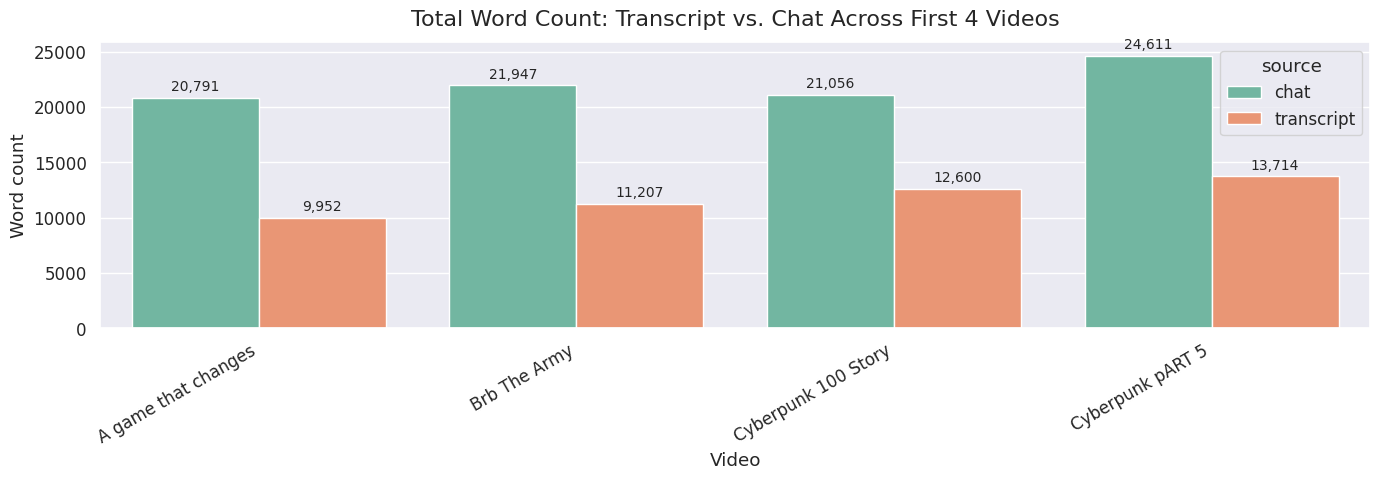

In [45]:
#Barplot

sns.set_theme(font_scale=1.1)

plt.figure(figsize=(14, 5))

ax = sns.barplot(
    data=filtered_word_counts_df,
    x="video_name_cleaned",
    y="word_count",
    hue="source",
    palette="Set2"
)

ax.set_title(
    "Total Word Count: Transcript vs. Chat Across First 4 Videos",
    fontsize=16,
    pad=12
)
ax.set_xlabel("Video")
ax.set_ylabel("Word count")

plt.xticks(rotation=30, ha="right")

# add labels on bars (same style as Jaccard plot)
for p in ax.patches:
    h = p.get_height()
    if h > 0:
        ax.annotate(
            f"{int(h):,}",
            (p.get_x() + p.get_width()/2, h),
            ha="center",
            va="bottom",
            fontsize=10,
            xytext=(0, 3),
            textcoords="offset points"
        )

plt.tight_layout()
plt.show()


###27. Vocabulary overlap

To what extent does the streamer use the same lexical items as the chat?

,video_name,video_name_cleaned,source_1,source_2,jaccard_types_norm,cosine_counts_norm,shared_types,union_types,vocab_types_src1,vocab_types_src2,tokens_src1,tokens_src2
3,Cyberpunk pART 5,Cyberpunk pART 5,chat,transcript,0.235281,0.790185,1091,4637,3616,2112,21020,12571
2,Cyberpunk 100 Story,Cyberpunk 100 Story,chat,transcript,0.233506,0.788746,945,4047,3054,1938,17715,11739
0,A game that changes,A game that changes,chat,transcript,0.230680,0.777520,797,3455,2847,1405,17563,9364
1,Brb The Army,Brb The Army,chat,transcript,0.199736,0.760723,757,3790,3324,1223,18296,9711


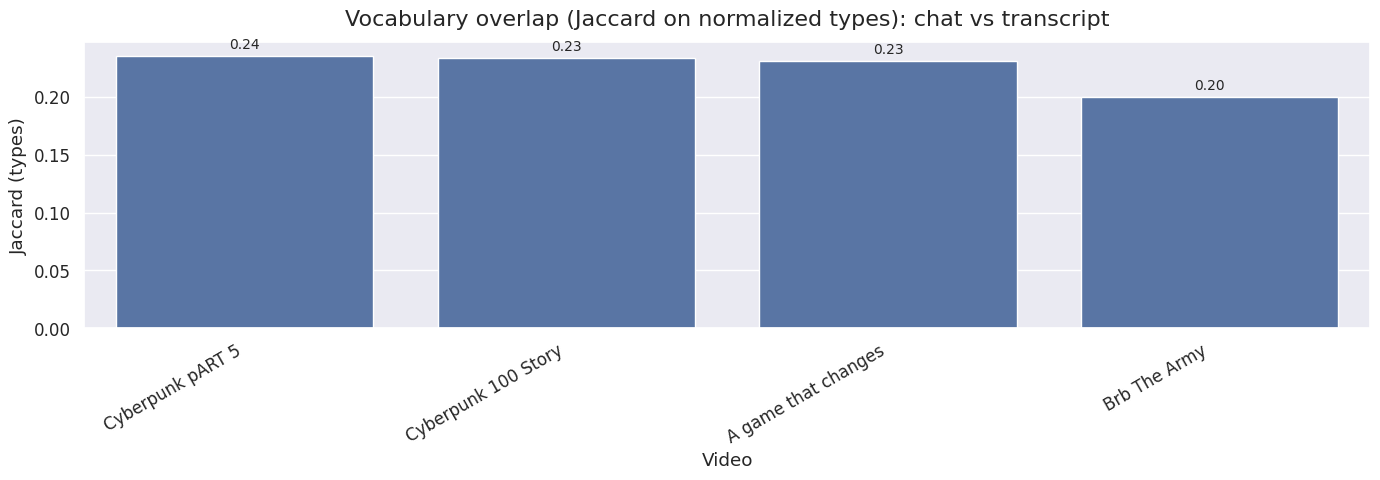

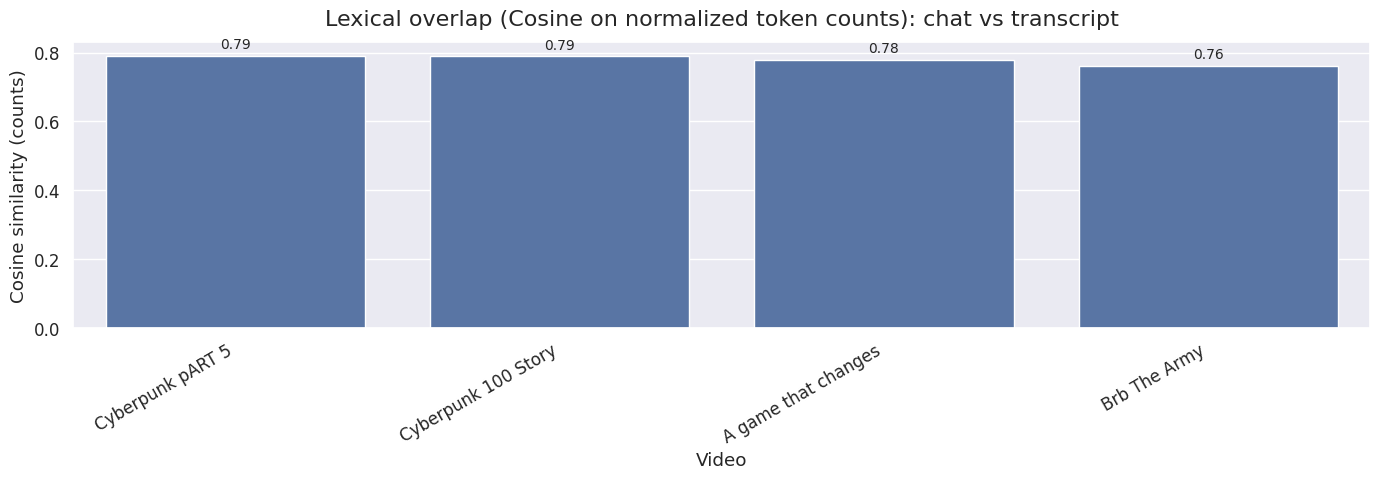

In [47]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

sns.set_theme(font_scale=1.1)

# ---------- Video label cleanup (optional, for plotting) ----------
def clean_video_name(x, max_len=20):
    name = x.split("--")[-1]
    name = re.sub(r'[^a-zA-Z0-9\s]', '', name).strip()
    return name[:max_len] + ("…" if len(name) > max_len else "")

# ---------- Token normalization + filtering ----------
EMOJI_RE = re.compile(
    "["                     # broad emoji block coverage
    "\U0001F300-\U0001FAFF"
    "\U00002700-\U000027BF"
    "\U00002600-\U000026FF"
    "]+", flags=re.UNICODE
)

def normalize_token(tok: str) -> str | None:
    if tok is None:
        return None
    t = str(tok).strip().lower()
    if not t:
        return None

    # drop emojis and purely symbolic tokens
    if EMOJI_RE.search(t):
        return None

    # must contain at least one alnum
    if not re.search(r"[a-z0-9]", t):
        return None

    # remove obvious punctuation noise (keep internal apostrophes if you want: adjust if needed)
    t = re.sub(r"[^a-z0-9'\-]+", "", t).strip("-'")

    if not t:
        return None

    # collapse elongations: "ahhhhh" -> "ahh", "nooooo" -> "noo"
    # (keeps some expressive length but stops infinite variants)
    t = re.sub(r"(.)\1{2,}", r"\1\1", t)

    # drop tokens that are now too short / junky (tune as needed)
    if len(t) == 1 and t not in {"a", "i"}:
        return None

    # optionally drop common chat fillers (add/remove as you like)
    # if t in {"lol", "lmao", "haha", "uh", "um"}: return None

    return t

def normalized_tokens(df):
    toks = []
    for row in df["processed_tokens"]:
        for tok in row:
            nt = normalize_token(tok)
            if nt is not None:
                toks.append(nt)
    return toks

# ---------- Similarity metrics ----------
def jaccard_types(tokens_a, tokens_b):
    A, B = set(tokens_a), set(tokens_b)
    inter = len(A & B)
    union = len(A | B)
    return (inter / union) if union else np.nan, inter, union, len(A), len(B)

def cosine_counts(tokens_a, tokens_b):
    ca, cb = Counter(tokens_a), Counter(tokens_b)
    keys = set(ca) | set(cb)
    if not keys:
        return np.nan
    dot = sum(ca[k] * cb[k] for k in keys)
    na = np.sqrt(sum(v*v for v in ca.values()))
    nb = np.sqrt(sum(v*v for v in cb.values()))
    return (dot / (na * nb)) if (na and nb) else np.nan

# ---------- Choose sources explicitly ----------
# Set these to match your actual labels exactly:
S1 = "chat"
S2 = "transcript"

# sanity check
srcs = set(total_vids_df["source"].unique())
if S1 not in srcs or S2 not in srcs:
    print("Available sources:", sorted(srcs))
    raise ValueError(f"Set S1/S2 to match your data. Missing: {[s for s in [S1,S2] if s not in srcs]}")

# ---------- Compute per-video overlap ----------
vids = filtered_word_counts_df["video_name"].unique()

rows = []
for vid in vids:
    sub = total_vids_df[total_vids_df["video_name"] == vid]
    if sub.empty:
        continue

    a_df = sub[sub["source"] == S1]
    b_df = sub[sub["source"] == S2]
    if a_df.empty or b_df.empty:
        continue

    toks_a = normalized_tokens(a_df)
    toks_b = normalized_tokens(b_df)

    jacc, inter, union, sizeA, sizeB = jaccard_types(toks_a, toks_b)
    cos = cosine_counts(toks_a, toks_b)

    rows.append({
        "video_name": vid,
        "video_name_cleaned": clean_video_name(vid),
        "source_1": S1,
        "source_2": S2,
        "jaccard_types_norm": jacc,
        "cosine_counts_norm": cos,
        "shared_types": inter,
        "union_types": union,
        "vocab_types_src1": sizeA,
        "vocab_types_src2": sizeB,
        "tokens_src1": len(toks_a),
        "tokens_src2": len(toks_b),
    })

overlap_df = pd.DataFrame(rows).sort_values("jaccard_types_norm", ascending=False)
display(overlap_df)

# ---------- Plot: Jaccard ----------
plt.figure(figsize=(14, 5))
ax = sns.barplot(data=overlap_df, x="video_name_cleaned", y="jaccard_types_norm")
ax.set_title(f"Vocabulary overlap (Jaccard on normalized types): {S1} vs {S2}", fontsize=16, pad=12)
ax.set_xlabel("Video")
ax.set_ylabel("Jaccard (types)")
plt.xticks(rotation=30, ha="right")

for p in ax.patches:
    h = p.get_height()
    if pd.notna(h):
        ax.annotate(f"{h:.2f}", (p.get_x() + p.get_width()/2, h),
                    ha="center", va="bottom", fontsize=10, xytext=(0, 3),
                    textcoords="offset points")
plt.tight_layout()
plt.show()

# ---------- Plot: Cosine ----------
plt.figure(figsize=(14, 5))
ax = sns.barplot(data=overlap_df, x="video_name_cleaned", y="cosine_counts_norm")
ax.set_title(f"Lexical overlap (Cosine on normalized token counts): {S1} vs {S2}", fontsize=16, pad=12)
ax.set_xlabel("Video")
ax.set_ylabel("Cosine similarity (counts)")
plt.xticks(rotation=30, ha="right")

for p in ax.patches:
    h = p.get_height()
    if pd.notna(h):
        ax.annotate(f"{h:.2f}", (p.get_x() + p.get_width()/2, h),
                    ha="center", va="bottom", fontsize=10, xytext=(0, 3),
                    textcoords="offset points")
plt.tight_layout()
plt.show()


###28. Chat density

When are there more or fewer chat messages?

Analyzing message density for video: Minecraft with Carso


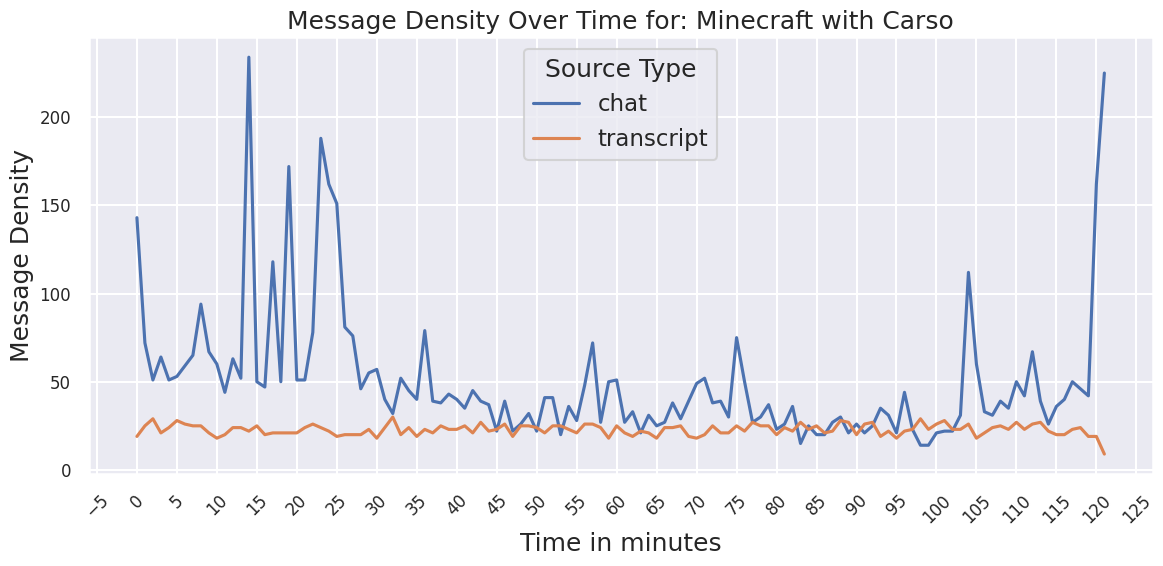

In [48]:
# Select a specific video for message density analysis
# Let's take the first video from the list of unique video names in total_vids_df
import matplotlib.ticker as ticker

if not total_vids_df.empty:
    selected_video_name = total_vids_df['video_name'].unique()[0]
    viz_df = total_vids_df[total_vids_df['video_name'] == selected_video_name].copy()
    print(f"Analyzing message density for video: {selected_video_name}")
else:
    print("total_vids_df is empty, cannot perform message density analysis.")
    viz_df = pd.DataFrame() # Create an empty DataFrame to avoid further errors

if not viz_df.empty:
    # Convert time to minutes (integer part)
    viz_df['time_in_minutes'] = (viz_df['time'] / 60).astype(int)

    # Group by time in minutes and source, then count messages
    # Unstack to get 'chat' and 'transcript' as separate columns
    mer2 = viz_df.groupby(['time_in_minutes', 'source']).size().unstack(fill_value=0).reset_index()

    # Rename columns for clarity if 'chat' or 'transcript' don't exist (e.g., if only one source is present)
    if 'chat' not in mer2.columns: mer2['chat'] = 0
    if 'transcript' not in mer2.columns: mer2['transcript'] = 0

    # Melt the DataFrame for plotting with seaborn.lineplot
    result_df2 = pd.melt(mer2, id_vars='time_in_minutes', value_vars=['chat', 'transcript'], var_name='Source Type', value_name='Message Count')

    # Create the plot
    sns.set_theme(style="darkgrid")
    sns.set_context("talk")
    plt.figure(figsize=(12, 6))
    ax = sns.lineplot(data=result_df2, x='time_in_minutes', y='Message Count', hue='Source Type')
    ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
    plt.xlabel('Time in minutes')
    plt.ylabel('Message Density')
    plt.title(f'Message Density Over Time for: {selected_video_name}')
    plt.xticks(fontsize="12", rotation=45)
    plt.yticks(fontsize="12")
    plt.tight_layout()
    plt.show()
else:
    print("No data to plot message density for the selected video.")

##Sentiment analysis


###29. Set up sentiment analysis

We will use a CardiffNLP model trained on Twitter messages. Other possibilities are commented out.

NOTE: This is really slow with cpu, but much faster with GPU (or a TPU).

In [49]:
from transformers import pipeline

# Choose a pre-trained sentiment analysis model
# 'sentiment-analysis' is the task, and you can specify a model name
# A common and good performing model is 'distilbert-base-uncased-finetuned-sst-2-english'
# However, for potential emoji handling, models trained on social media data might be better.
# Let's start with a general one and see how it performs, then explore others if needed.
# We will use 'cardiffnlp/twitter-roberta-base-sentiment-latest' as it is trained on Twitter data and might handle informal language better.

# Load the sentiment analysis pipeline
sentiment = pipeline(
    "sentiment-analysis",
    #model="finiteautomata/bertweet-base-sentiment-analysis",
    #model="distilbert-base-uncased-finetuned-sst-2-english",
    model="cardiffnlp/twitter-xlm-roberta-base-sentiment",
    truncation=True,
    max_length=512,
    batch_size=32,
)

print(f"Sentiment analysis pipeline loaded")

config.json:   0%|          | 0.00/841 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

XLMRobertaForSequenceClassification LOAD REPORT from: cardiffnlp/twitter-xlm-roberta-base-sentiment
Key                             | Status     |  | 
--------------------------------+------------+--+-
roberta.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Sentiment analysis pipeline loaded


In [51]:
sentiment(["I love this", "🙁☹️", "😭", "what?"])

[{'label': 'positive', 'score': 0.9215149879455566},
 {'label': 'negative', 'score': 0.8054936528205872},
 {'label': 'negative', 'score': 0.6881707906723022},
 {'label': 'neutral', 'score': 0.5548458099365234}]

###30. Filter our YouTube data.

This sentiment model doesn't like NaN values, empty rows, or unexpected Unicode codepoints. Let's filter the data.  

In [52]:
import numpy as np

print(f"Original row count: {len(total_vids_df)}")

# 1. Force everything to string and handle NaNs properly
# Using a single space " " is safer than an empty string "" for some tokenizers
total_vids_df['Content'] = total_vids_df['Content'].astype(str).fillna(" ").replace('nan', ' ')

# 2. Strip whitespace and remove any remaining "empty" rows that are just noise
total_vids_df['Content'] = total_vids_df['Content'].str.strip()

# 3. CRITICAL: Remove actual empty rows.
# A completely empty string can sometimes cause the GPU to receive a 0-length tensor,
# which triggers the 'device-side assert' error.
total_vids_df = total_vids_df[total_vids_df['Content'] != ""].copy()

# 4. Filter out any potential non-printable characters or corrupt bytes
total_vids_df['Content'] = total_vids_df['Content'].apply(
    lambda x: "".join(i for i in x if i.isprintable())
)

print(f"Cleaned row count: {len(total_vids_df)}")
print("Data is now safe for GPU pipeline.")

Original row count: 667035
Cleaned row count: 667033
Data is now safe for GPU pipeline.


###31. Convert to a dataset and assign sentiment values

In [ ]:
import torch
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
from transformers.pipelines.pt_utils import KeyDataset
from datasets import Dataset
from tqdm.auto import tqdm

# 1) Dataset
ds = Dataset.from_pandas(total_vids_df[["Content"]].fillna(""))

# 2) Load model + tokenizer properly
model_name = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    low_cpu_mem_usage=True
)

# 3) Force eager attention (bypasses SDPA CUDA path)
if hasattr(model.config, "attn_implementation"):
    model.config.attn_implementation = "eager"

# 4) Pipeline (note task name + explicit tokenizer/model)
pipe = pipeline(
    "text-classification",          # use this for these models
    model=model,
    tokenizer=tokenizer,
    device=0,
    truncation=True,
    padding=True,
    max_length=256,                 # keeps things stable + fast
    return_all_scores=False
)

# 5) Run
results = []
print(f"Starting sentiment analysis for {len(ds)} entries...")

for out in tqdm(pipe(KeyDataset(ds, "Content"), batch_size=32), total=len(ds)):
    results.append(out)

# 6) Save
total_vids_df["sentiment"] = [r["label"] for r in results]
total_vids_df["score"] = [float(r["score"]) for r in results]


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

XLMRobertaForSequenceClassification LOAD REPORT from: cardiffnlp/twitter-xlm-roberta-base-sentiment
Key                             | Status     |  | 
--------------------------------+------------+--+-
roberta.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Starting sentiment analysis for 667033 entries...


  0%|          | 0/667033 [00:00<?, ?it/s]

In [ ]:
total_vids_df

,time,source,platform,Content,author,video_name,uploader,processed_tokens,word_count,sentiment,score
0,-26.0,chat,YouTube,Damn it,Corrupted Redemption <img src=https://yt3.ggph...,Minecraft with Carso…,PewDiePie,"[damn, it]",2,negative,0.874574
1,-25.0,chat,YouTube,welcome,kaitlyn golab <img src=https://yt3.ggpht.com/6...,Minecraft with Carso…,PewDiePie,[welcome],1,positive,0.390005
2,-23.0,chat,YouTube,yes,Shani Ohana <img src=https://yt3.ggpht.com/6YY...,Minecraft with Carso…,PewDiePie,[yes],1,neutral,0.427089
3,-23.0,chat,YouTube,early gang,kaitlyn golab <img src=https://yt3.ggpht.com/6...,Minecraft with Carso…,PewDiePie,"[early, gang]",2,neutral,0.402569
4,-23.0,chat,YouTube,n ice,Dylen Goodrunning <img src=https://yt3.ggpht.c...,Minecraft with Carso…,PewDiePie,"[n, ice]",2,negative,0.379750
...,...,...,...,...,...,...,...,...,...,...,...
667030,8164.0,chat,YouTube,it was fun lol,@raraysaya <img src=https://yt3.ggpht.com/e_78...,Fall Guys ALL WINS G…,PewDiePie,"[it, was, fun, lol]",4,positive,0.781031
667031,8164.0,chat,YouTube,□,@ahyliiyo <img src=https://yt3.ggpht.com/gAq7j...,Fall Guys ALL WINS G…,PewDiePie,[□],1,neutral,0.488640
667032,8164.0,chat,YouTube,love ya,@鍾敬逸 <img src=https://yt3.ggpht.com/Otv-LqYLhR...,Fall Guys ALL WINS G…,PewDiePie,"[love, ya]",2,positive,0.647345
667033,8164.0,chat,YouTube,if you want to win just win like really,@swaglikeits99 <img src=https://yt3.ggpht.com/...,Fall Guys ALL WINS G…,PewDiePie,"[if, you, want, to, win, just, win, like, really]",9,positive,0.444084


###32. Assign sentiment to n-second bins

This may be better than assigning sentiment to every single row.

In [53]:
import re
import pandas as pd

BRACKET_RE = re.compile(r'^\s*\[.*?\]\s*$')
TAG_RE = re.compile(r'<[^>]+>')          # removes <img ...> etc.
WS_RE = re.compile(r'\s+')

def clean_html(t: str) -> str:
    if not isinstance(t, str):
        return ""
    t = TAG_RE.sub(" ", t)              # drop tags
    t = WS_RE.sub(" ", t).strip()
    return t

def is_junk(t: str) -> bool:
    if not isinstance(t, str):
        return True
    t = t.strip()
    if not t:
        return True
    if BRACKET_RE.match(t):             # [Music], [Applause]
        return True
    if len(t) < 4:
        return True
    if len(t.split()) < 2:
        return True
    return False

def assign_sentiment_over_time(
    df,
    sentiment,                   # pass your HF pipeline in
    text_col="Content",
    time_col="time",
    source_col="source",
    window=20,
    batch_size=64,
    max_length=256,
    return_all_scores=True
):
    d = df.copy()

    # Clean HTML out of the text (important for chat rows with <img>)
    d[text_col] = d[text_col].apply(clean_html)

    # drop junk rows after cleaning
    d = d[~d[text_col].apply(is_junk)].copy()

    # bin time (assumes seconds; if your time is ms, adjust window accordingly)
    t0 = d[time_col].min()
    d["time_bin"] = ((d[time_col] - t0) // window).astype(int)


    # concatenate text within each (source, time_bin)
    binned = (
        d.groupby([source_col, "time_bin"], sort=True)
         .agg(
             start_time=(time_col, "min"),
             end_time=(time_col, "max"),
             text=(text_col, lambda s: " ".join(s.astype(str)))
         )
         .reset_index()
    )

    texts = binned["text"].tolist()

    # run sentiment
    outputs = sentiment(
        texts,
        truncation=True,
        padding=True,
        max_length=max_length,
        batch_size=batch_size,
        return_all_scores=return_all_scores
    )

    # ---- robust mapping to numeric score ----
    POS_KEYS = {"positive", "pos", "label_2", "2"}
    NEG_KEYS = {"negative", "neg", "label_0", "0"}
    NEU_KEYS = {"neutral", "neu", "label_1", "1"}

    def norm_label(lab: str) -> str:
        lab = (lab or "").strip().lower()
        return lab

    def to_num(x):
        # return_all_scores=True => x is a list of dicts [{'label':..., 'score':...}, ...]
        if isinstance(x, list):
            scores = {norm_label(d["label"]): float(d["score"]) for d in x}
            # pick best matching keys present
            pos = 0.0
            neg = 0.0
            for k, v in scores.items():
                if k in POS_KEYS or "pos" in k:
                    pos = max(pos, v)
                if k in NEG_KEYS or "neg" in k:
                    neg = max(neg, v)
            return pos - neg

        # top label only
        lab = norm_label(x.get("label"))
        sc = float(x.get("score", 0.0))

        if lab in POS_KEYS or "pos" in lab:
            return sc
        if lab in NEG_KEYS or "neg" in lab:
            return -sc
        if lab in NEU_KEYS or "neu" in lab:
            return 0.0

        # unknown label: treat as neutral
        return 0.0

    binned["sentiment"] = [to_num(o) for o in outputs]
    return binned


###33. Assign sentiment to the start of the YouTube content

In [54]:
WINDOW = 20  # seconds; try 5, 10, 20

sentiment = pipeline(
    "text-classification",
    model="cardiffnlp/twitter-xlm-roberta-base-sentiment",
    device=0,
    truncation=True,
    padding=True,
    max_length=256,
    return_all_scores=True
)

binned = assign_sentiment_over_time(total_vids_df.iloc[:3000], sentiment, window=20)
binned

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

XLMRobertaForSequenceClassification LOAD REPORT from: cardiffnlp/twitter-xlm-roberta-base-sentiment
Key                             | Status     |  | 
--------------------------------+------------+--+-
roberta.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


,source,time_bin,start_time,end_time,text,sentiment
0,chat,0,-26.000,-7.00,Damn it n ice early gang I was first THANK GOD...,0.577842
1,chat,1,-6.000,12.00,Hopefully it will work this time big rip inter...,-0.808753
2,chat,2,16.000,33.00,early gang go brrr What happened ? Slow modeee...,0.620574
3,chat,3,37.000,53.00,We did get to see anything! no more lagging we...,0.422563
4,chat,4,54.000,72.00,SEE YOU GUYS IN 60 SECONDS premium quality str...,-0.435298
...,...,...,...,...,...,...
160,transcript,78,1536.480,1550.72,that get under my skin yeah more than so barre...,-0.814574
161,transcript,79,1556.640,1568.00,yeah i agree barrels close third hey hey races...,0.000000
162,transcript,80,1574.720,1592.32,just like that that didn't make anything make ...,-0.621864
163,transcript,81,1594.559,1608.32,that's that's a good sign uh well technically ...,0.648084


In [55]:
binned[binned["source"]=="transcript"]

,source,time_bin,start_time,end_time,text,sentiment
83,transcript,1,0.240,13.440,let us end it's cold we're already inside like...,0.523620
84,transcript,2,18.880,27.279,i i don't want to do it i changed my mind all ...,0.000000
85,transcript,3,39.280,52.719,let us leave oh let us leave you should have s...,0.000000
86,transcript,4,54.640,71.360,we if we gallivant this way all right stream i...,0.499375
87,transcript,5,74.000,93.200,there this is the what well i see it alright o...,0.000000
...,...,...,...,...,...,...
160,transcript,78,1536.480,1550.720,that get under my skin yeah more than so barre...,-0.814574
161,transcript,79,1556.640,1568.000,yeah i agree barrels close third hey hey races...,0.000000
162,transcript,80,1574.720,1592.320,just like that that didn't make anything make ...,-0.621864
163,transcript,81,1594.559,1608.320,that's that's a good sign uh well technically ...,0.648084


###34. Plot sentiment for the start of the content

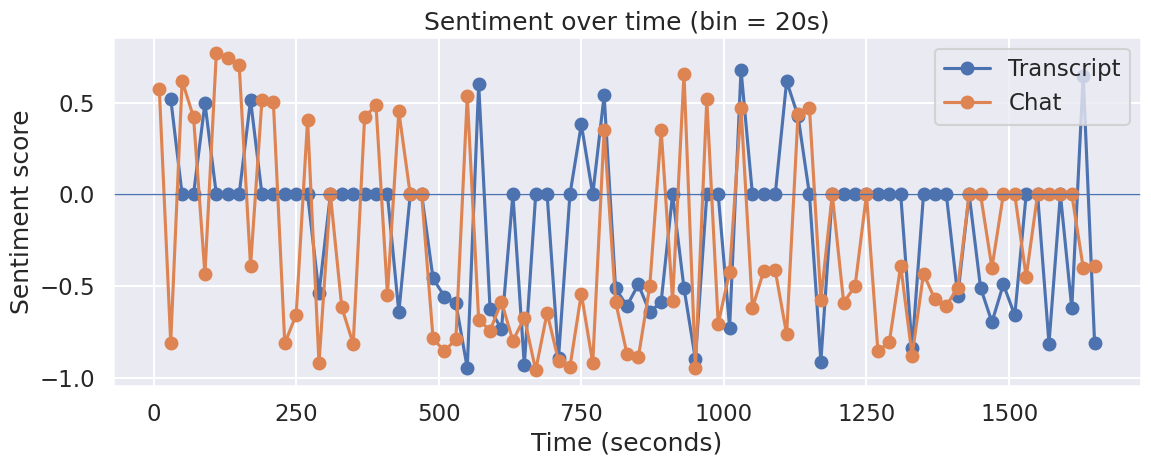

source,time_bin,chat,transcript,t_sec
0,0,0.577842,NaN,10.0
1,1,-0.808753,0.523620,30.0
2,2,0.620574,0.000000,50.0
3,3,0.422563,0.000000,70.0
4,4,-0.435298,0.499375,90.0
5,5,0.771409,0.000000,110.0
6,6,0.747176,0.000000,130.0
7,7,0.709056,0.000000,150.0
8,8,-0.391146,0.515656,170.0
9,9,0.516564,0.000000,190.0


In [56]:
import matplotlib.pyplot as plt

# pivot to wide: rows = time bins, columns = sources
wide = (
    binned
    .pivot_table(index="time_bin", columns="source", values="sentiment", aggfunc="mean")
    .sort_index()
    .reset_index()
)

# nicer x-axis in seconds
wide["t_sec"] = wide["time_bin"] * WINDOW + (WINDOW / 2)

plt.figure(figsize=(12, 5))

if "transcript" in wide.columns:
    plt.plot(wide["t_sec"], wide["transcript"], marker="o", label="Transcript")

if "chat" in wide.columns:
    plt.plot(wide["t_sec"], wide["chat"], marker="o", label="Chat")

plt.axhline(0, linewidth=1)
plt.title(f"Sentiment over time (bin = {WINDOW}s)")
plt.xlabel("Time (seconds)")
plt.ylabel("Sentiment score")
plt.legend()
plt.tight_layout()
plt.show()

display(wide.head(10))


###35. Correlation of chat and transcript sentiment

In [57]:

sent_map = {
    "positive":  1,
    "neutral":   0,
    "negative": -1
}

df = total_vids_df.copy()
df["sentiment_num"] = df["sentiment"].map(sent_map)

window = 30  # seconds
df["time_bin"] = (df["time"] // window).astype(int)

agg = (
    df.groupby(["time_bin", "source"])["sentiment_num"]
      .mean()
      .unstack("source")
      .dropna()   # keep bins where both chat & transcript exist
)

corr = agg["chat"].corr(agg["transcript"])
corr


KeyError: 'sentiment'

###36. Moving average Type-Token Ratio



,video_name,source,mattr
0,A game that changes …,chat,0.747264
1,A game that changes …,transcript,0.693053
2,Brb The Army,chat,0.769353
3,Brb The Army,transcript,0.627695
4,Cyberpunk pART 5,chat,0.778077


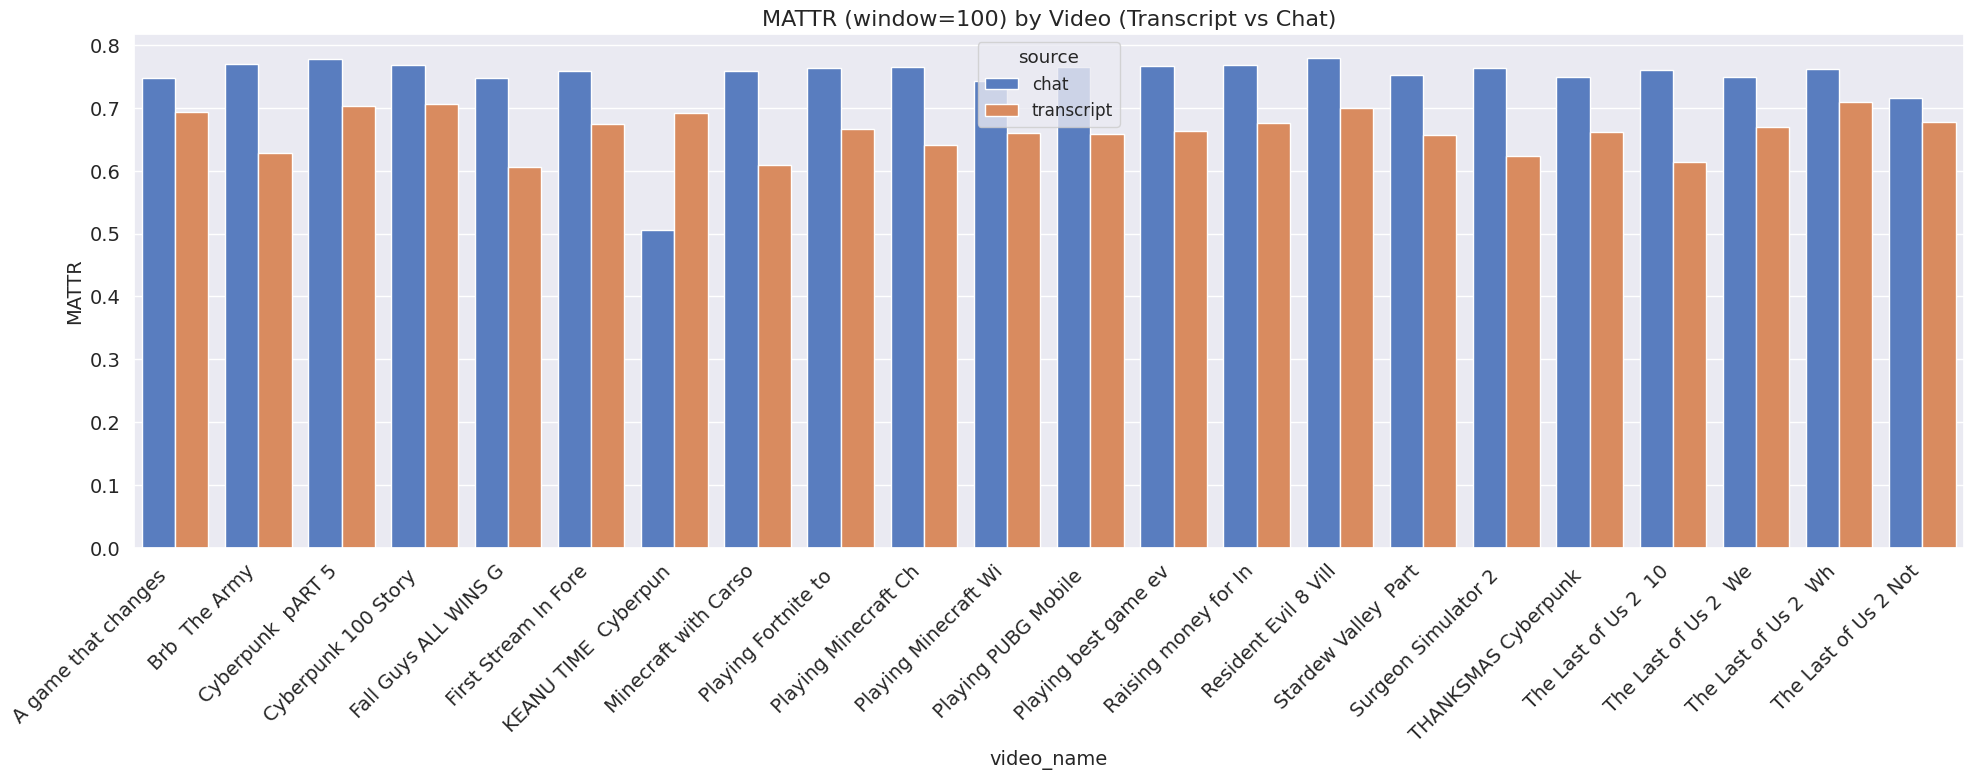

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(font_scale=1.1)

def flatten_token_lists(series):
    out = []
    for x in series:
        if isinstance(x, list):
            out.extend(x)
    return out

def mattr(tokens, window=100):
    # Moving-Average TTR
    if not tokens:
        return 0.0
    n = len(tokens)
    if n <= window:
        return len(set(tokens)) / n
    ttrs = []
    for i in range(0, n - window + 1):
        w = tokens[i:i+window]
        ttrs.append(len(set(w)) / window)
    return sum(ttrs) / len(ttrs)

WINDOW = 100  # change (50/100/200) depending on how long your texts are

# ---- aggregate tokens by video + source ----
agg = (
    total_vids_df
    .groupby(["video_name", "source"], as_index=False)["processed_tokens"]
    .apply(lambda g: flatten_token_lists(g))
    .rename(columns={"processed_tokens": "all_tokens"})
)

agg["mattr"] = agg["all_tokens"].apply(lambda toks: mattr(toks, window=WINDOW))
agg["video_name_cleaned"] = agg["video_name"].astype(str).str.split("--").str[-1].str.slice(0, 20)

display(agg[["video_name", "source", "mattr"]].sort_values(["video_name", "source"]).head())

# ---- plot ----
plt.figure(figsize=(20, 8))
ax = sns.barplot(
    data=agg,
    x="video_name_cleaned",
    y="mattr",
    hue="source",
    palette="muted"
)
plt.title(f"MATTR (window={WINDOW}) by Video (Transcript vs Chat)", fontsize=16)
plt.xticks(rotation=45, ha="right", fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("MATTR", fontsize=14)
plt.xlabel("video_name", fontsize=14)
plt.tight_layout()
plt.show()


###37. Vocabulary Growth Curves


Chat tokens: 2540724
Transcript tokens: 337304
Comparing first N=337304 tokens from each


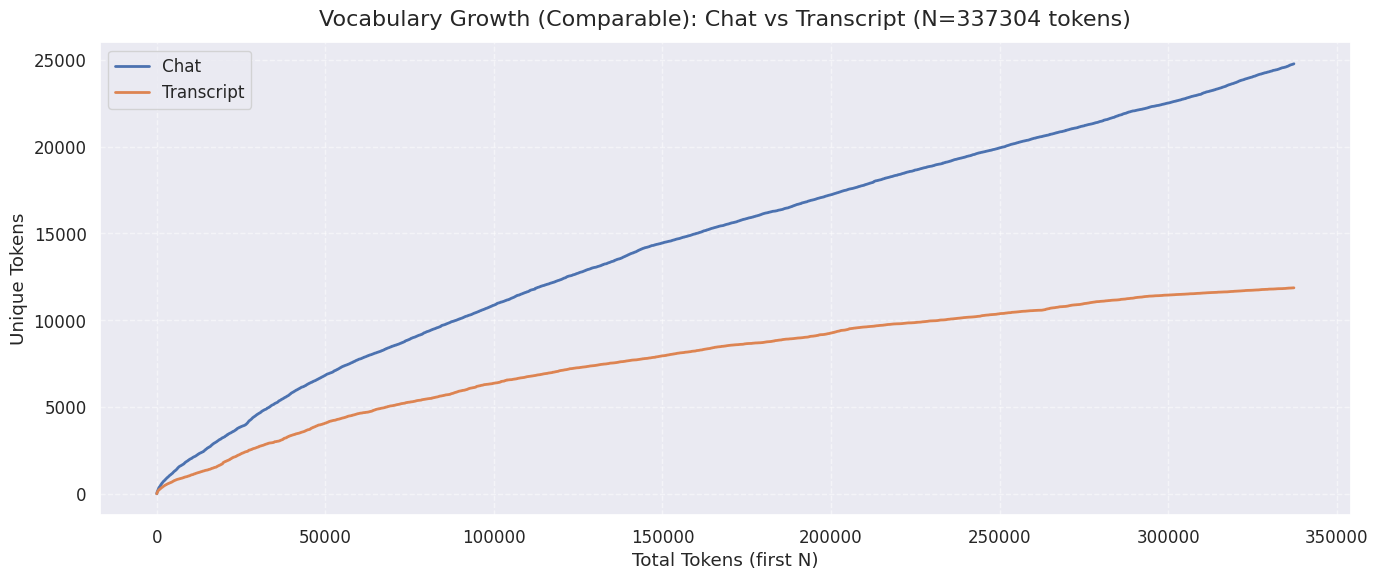

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain
import numpy as np

sns.set_theme(font_scale=1.1)

def vocab_growth(tokens, max_n=None):
    unique = set()
    xs, ys = [], []
    n = len(tokens) if max_n is None else min(len(tokens), max_n)
    for i in range(n):
        unique.add(tokens[i])
        xs.append(i + 1)
        ys.append(len(unique))
    return np.array(xs), np.array(ys)

# split by source
chat_tokens = list(chain.from_iterable(
    total_vids_df.loc[total_vids_df["source"] == "chat", "processed_tokens"]
))
transcript_tokens = list(chain.from_iterable(
    total_vids_df.loc[total_vids_df["source"] == "transcript", "processed_tokens"]
))

# ---- make comparable: truncate to same token count ----
N = min(len(chat_tokens), len(transcript_tokens))
print(f"Chat tokens: {len(chat_tokens)}")
print(f"Transcript tokens: {len(transcript_tokens)}")
print(f"Comparing first N={N} tokens from each")

x_chat, y_chat = vocab_growth(chat_tokens, max_n=N)
x_tr, y_tr = vocab_growth(transcript_tokens, max_n=N)

plt.figure(figsize=(14, 6))
plt.plot(x_chat, y_chat, label="Chat", linewidth=2)
plt.plot(x_tr, y_tr, label="Transcript", linewidth=2)

plt.title(f"Vocabulary Growth (Comparable): Chat vs Transcript (N={N} tokens)", fontsize=16, pad=12)
plt.xlabel("Total Tokens (first N)")
plt.ylabel("Unique Tokens")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


###Zipf's Law



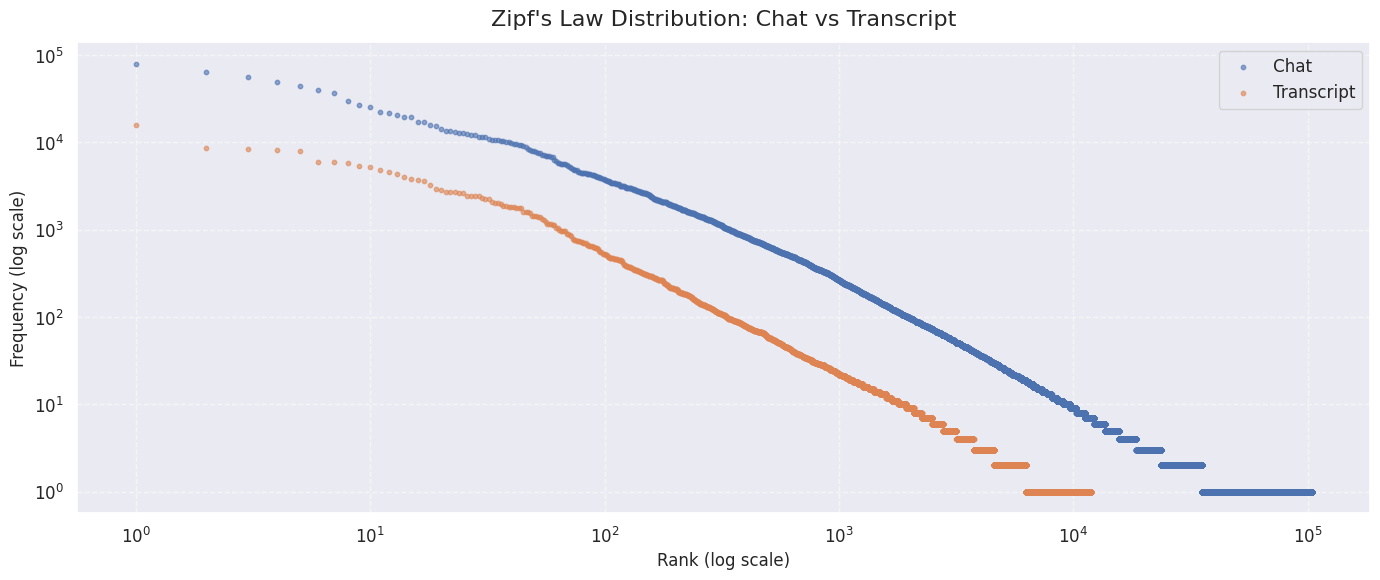

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import numpy as np
from itertools import chain

sns.set_theme(font_scale=1.1)

# ---- split tokens by source ----
chat_tokens = list(chain.from_iterable(
    total_vids_df.loc[total_vids_df["source"] == "chat", "processed_tokens"]
))

transcript_tokens = list(chain.from_iterable(
    total_vids_df.loc[total_vids_df["source"] == "transcript", "processed_tokens"]
))

def zipf_data(tokens):
    counter = collections.Counter(tokens)
    freqs = np.array([c for _, c in counter.most_common()])
    ranks = np.arange(1, len(freqs) + 1)
    return ranks, freqs

# compute Zipf distributions
r_chat, f_chat = zipf_data(chat_tokens)
r_tr, f_tr = zipf_data(transcript_tokens)

# ---- plot ----
plt.figure(figsize=(14, 6))

plt.scatter(r_chat, f_chat, alpha=0.6, s=10, label="Chat")
plt.scatter(r_tr, f_tr, alpha=0.6, s=10, label="Transcript")

plt.xscale("log")
plt.yscale("log")

plt.title("Zipf's Law Distribution: Chat vs Transcript", fontsize=16, pad=12)
plt.xlabel("Rank (log scale)", fontsize=12)
plt.ylabel("Frequency (log scale)", fontsize=12)

plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()
